In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import cv2
from datetime import datetime
from tensorflow.keras.models import load_model

In [2]:
tf.test.is_gpu_available()

True

In [3]:
def show_images(images, nrof_columns, fig=None):
    batch, width, height, depth = images.shape
    nrof_rows = int(np.ceil(batch/nrof_columns)) 
    out = np.zeros((nrof_rows*height, nrof_columns*width, depth), dtype=np.float32)
    for i in range(batch):
        x = i % nrof_columns
        y = i // nrof_columns
        out[y*height:(y+1)*height,x*width:(x+1)*width,:] = images[i,:,:,:]
    out[0::height,:,:] = 1.0
    out[:,0::width,:] = 1.0
    out[1::height,:,:] = 1.0
    out[:,1::width,:] = 1.0
    plt.imshow(out)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

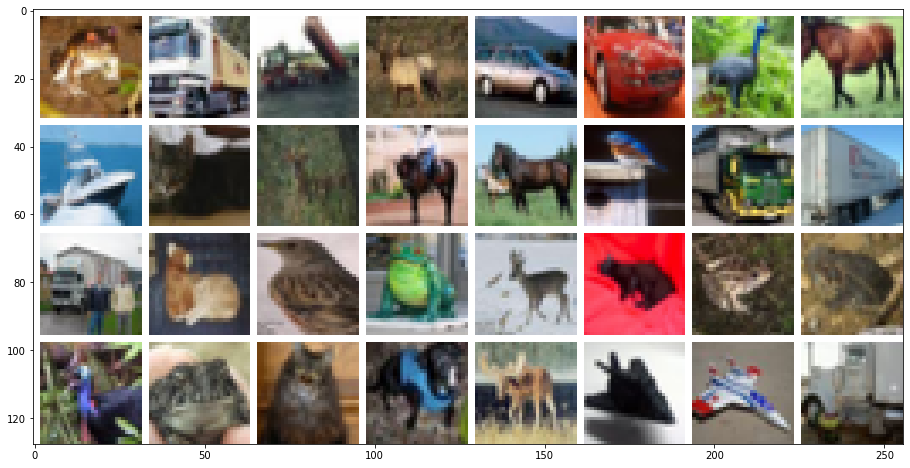

In [5]:
fig = plt.figure(figsize=(16,8))
show_images(x_train[:32,...]/256, 8)

In [6]:
def BN(x, is_training=True):
    y = tf.layers.batch_normalization(x, center=True, scale=True, training=is_training)
    return y

# NHWC: Spatial Upsampling
def upsample_conv2d(x, *, filter_size=(3, 3), n_filters=256):
    _x = tf.concat([x, x, x, x], axis=-1)
    _x = tf.depth_to_space(_x, block_size=2)
    _x = tf.layers.conv2d(_x, filters=n_filters, kernel_size=filter_size, padding='SAME')
    return _x

# NHWC: Spatial Upsampling
def downsample_conv2d(x, *, filter_size=(3, 3), n_filters=256):
    _x = tf.space_to_depth(x, block_size=2)
    _x = tf.add_n(tf.split(_x, 4, axis=-1))/4.
    _x = tf.layers.conv2d(_x, filters=n_filters, kernel_size=filter_size, padding='SAME')
    return _x

# NHWC:
def ResBlockUp(x, *, filter_size=(3, 3), n_filters=256, scope='up_block'):
    _x = x
    with tf.variable_scope(scope):
        _x = BN(_x)
        _x = tf.nn.relu(_x)
        _x = tf.layers.conv2d(_x, filters=n_filters, kernel_size=filter_size, padding='SAME')
        _x = BN(_x)
        _x = tf.nn.relu(_x)
        residual = upsample_conv2d(_x, filter_size=filter_size, n_filters=n_filters)
        shortcut = upsample_conv2d(x, filter_size=(1, 1), n_filters=n_filters)

        return shortcut + residual
    
# NHWC: XXX
def ResBlockDown(x, *, filter_size=(3, 3), n_filters=256, scope='down_block'):
    _x = x
    with tf.variable_scope(scope):
        _x = tf.nn.relu(_x)
        _x = tf.layers.conv2d(_x, filters=n_filters, kernel_size=filter_size, padding='SAME')
        _x = tf.nn.relu(_x)
        residual = downsample_conv2d(_x, filter_size=filter_size, n_filters=n_filters)
        shortcut = downsample_conv2d(x, filter_size=(1, 1), n_filters=n_filters)

        return shortcut + residual
    
# NHWC: XXX
def ResBlock(x, *, filter_size=(3, 3), n_filters=256, scope='down_block'):
    _x = x
    with tf.variable_scope(scope):
        _x = tf.nn.relu(_x)
        _x = tf.layers.conv2d(_x, filters=n_filters, kernel_size=filter_size, padding='SAME')
        _x = tf.nn.relu(_x)
        residual = tf.layers.conv2d(_x, filters=n_filters, kernel_size=filter_size, padding='SAME')
        shortcut = x  # For a regular ResBlock the shortcut is just the identity connection

        return shortcut + residual
    
def global_sum_pooling(inputs):
    outputs = tf.reduce_sum(inputs, [1, 2], keep_dims=False)
    return outputs

In [7]:
# NHWC:
def Generator(z, n_filters):
    out = tf.layers.dense(z, 4 * 4 * n_filters)
    out = tf.reshape(out, [-1, 4, 4, n_filters])
    for block in range(3):
        out = ResBlockUp(out, filter_size=(3, 3), n_filters=n_filters, scope='res_up_%d' % block)

    out = BN(out)
    out = tf.nn.relu(out)
    out = tf.layers.conv2d(out, filters=3, kernel_size=(3, 3), padding='SAME')
    out = tf.nn.tanh(out)
    return out

# NHWC:
def Discriminator(x, n_filters):
    out = x
    for block in range(2):
        out = ResBlockDown(out, filter_size=(3, 3), n_filters=n_filters, scope='res_down_%d' % block)
    for block in range(2):
        out = ResBlock(out, filter_size=(3, 3), n_filters=n_filters, scope='res_%d' % block)
    out = tf.nn.relu(out)
    out = global_sum_pooling(out)
    out = tf.layers.dense(out, 1)
    return out

In [8]:
def create_dataset(x, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.repeat()   # Repeat the dataset indefinitely
    dataset = dataset.shuffle(10000)   # Shuffle the data
    dataset = dataset.batch(batch_size)  # Create batches of data
    dataset = dataset.prefetch(batch_size)  # Prefetch data for faster consumption
    iterator = tf.compat.v1.data.make_initializable_iterator(dataset)  # Create an iterator over the dataset
    return iterator

In [9]:
def resize(data, size):
    scaled = np.zeros((data.shape[0],) + size + (3,))
    for i, img in enumerate(data):
        scaled[i,...] = cv2.resize(img, dsize=size, interpolation=cv2.INTER_CUBIC)
    return scaled

def score(preds, splits=10):
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

def get_inception_score(images, model, splits=10):
    preds = model.predict(images)
    mean, std = score(preds, splits)
    return mean, std  # Reference values: 11.38 for 50000 CIFAR-10 training set images, or mean=11.31, std=0.10 if in 10 splits.

In [10]:
def train(nrof_steps, batch_size, n_filters):
    n_critic = 5
    gp_lambda = 10
    nrof_decay_steps = 100000
    base_learning_rate = 2e-4
    print_every_n_steps = 10
    
    model_name = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')

    tf.set_random_seed(42)
    np.random.seed(42)

    graph1 = tf.Graph()
    with graph1.as_default():
        sess1 = tf.Session()
        with sess1.as_default():
            is_model = load_model('inception_resnet_v2_cifar10.h5')

    graph = tf.Graph()
    with graph.as_default():
        train_iterator = create_dataset(x_train.astype(np.float32)/256, batch_size)

        with tf.compat.v1.variable_scope('generator', reuse=False):
            z = tf.random_normal([batch_size, 128])
            fakes = Generator(z, n_filters=n_filters)
        with tf.compat.v1.variable_scope('discriminator', reuse=False):
            D_fake = Discriminator(fakes, n_filters=n_filters)
        with tf.compat.v1.variable_scope('discriminator', reuse=True):
            reals = train_iterator.get_next()
            D_real = Discriminator(reals, n_filters=n_filters)

        epsilon = tf.random_uniform(shape=[batch_size, 1, 1, 1], minval=0., maxval=1.)
        interpolated_images = epsilon*fakes + (1-epsilon)*reals

        with tf.compat.v1.variable_scope('discriminator', reuse=True):
            D_interpolated = Discriminator(interpolated_images, n_filters=n_filters)

        grad_d_interpolated = tf.gradients(D_interpolated, [interpolated_images])[0]
        slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad_d_interpolated), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2)

        loss_d = tf.reduce_mean(D_fake - D_real) + gp_lambda*gradient_penalty
        loss_g = -tf.reduce_mean(D_fake)

        vars_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        vars_g = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

        learning_rate = tf.placeholder(tf.float32, shape=())

        opt_d = tf.train.AdamOptimizer(learning_rate=learning_rate,
            beta1=0, beta2=0.9).minimize(loss_d, var_list=vars_d)
        opt_g = tf.train.AdamOptimizer(learning_rate=learning_rate,
            beta1=0, beta2=0.9).minimize(loss_g, var_list=vars_g)
        
        saver = tf.train.Saver(max_to_keep=2)

        sess = tf.compat.v1.InteractiveSession()
        sess.run(tf.compat.v1.global_variables_initializer())
        sess.run(train_iterator.initializer)

        d_losses, g_losses, d_losses_tot, g_losses_tot, is_means, is_stds = [], [], [], [], [], []
        t = time.time()
        for step in range(nrof_steps + 1):
            lr = np.maximum(0.0, 1.0-step/nrof_decay_steps) * base_learning_rate
            # Optimize the critic for several rounds
            for _ in range(n_critic):
                loss_d_, _ = sess.run([loss_d, opt_d], feed_dict={learning_rate:lr})
                d_losses += [loss_d_]
                d_losses_tot += [loss_d_]

            # Sample noise and optimize the generator
            loss_g_, fakes_, _ = sess.run([loss_g, fakes, opt_g], feed_dict={learning_rate:lr})
            g_losses += [loss_g_]
            g_losses_tot += [loss_g_]

            if step % print_every_n_steps == 0:
                time_per_step = (time.time() - t) / print_every_n_steps
                t = time.time()
                print('step: %5d   time: %7.3f  lr: %10.7e  loss_d: %7.3f  loss_g: %7.3f' % (
                    step, time_per_step, lr, np.mean(d_losses), np.mean(g_losses)))
                d_losses = []
                g_losses = []
            if step % 1000 == 0:
                # Show some generated images
                fig = plt.figure(figsize=(16,8))
                ix = fakes_[:8,...]
                imgs = (ix-np.min(ix)) / (np.max(ix)-np.min(ix))
                show_images(imgs, 8)
                plt.show(fig)
            if step % 1000 == 0:
                # Calculate inception score
                imgs = []
                img_arr = []
                for k in range(int(np.floor(10000/batch_size))):
                    z_ = np.random.randn(batch_size, 128)
                    fakes_ = sess.run(fakes, feed_dict={z:z_})
                    img_arr += [ fakes_ ]
                imgs = np.vstack(img_arr)
                imgs = resize(imgs, size=(96,96))
                with graph1.as_default():
                    with sess1.as_default():
                        is_mean, is_std = get_inception_score(imgs, is_model, splits=10)
                is_means += [ is_mean ]
                is_stds += [ is_std ]
                print('Inception score: %7.3f +- %7.3f' % (is_mean, is_std))
            if step % 1000 == 0:
                saver.save(sess, model_name, global_step=step)
                
    z_ = np.random.randn(batch_size, 128)
    fakes_ = sess.run(fakes, feed_dict={z:z_})
    
    return d_losses_tot, g_losses_tot, is_means, is_stds, fakes_

# Train with batch_size=128 and n_filters=256 

W1230 23:13:10.051866 140151199811392 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1230 23:13:10.052603 140151199811392 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1230 23:13:10.053160 140151199811392 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorfl

step:     0   time:   0.416  lr: 2.0000000e-04  loss_d:  -8.804  loss_g:  -8.283


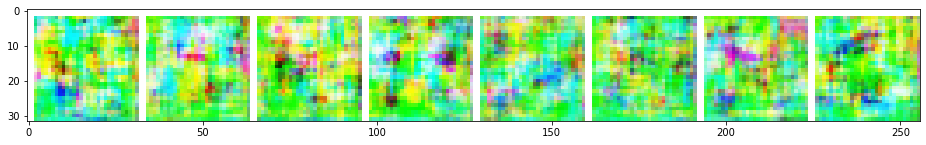

Inception score:   1.626 +-   0.018
step:    10   time:   3.447  lr: 1.9998000e-04  loss_d: -22.215  loss_g:  53.403
step:    20   time:   1.196  lr: 1.9996000e-04  loss_d: -15.403  loss_g:  33.477
step:    30   time:   1.200  lr: 1.9994000e-04  loss_d: -15.319  loss_g:  22.636
step:    40   time:   1.201  lr: 1.9992000e-04  loss_d: -13.808  loss_g:  18.545
step:    50   time:   1.208  lr: 1.9990000e-04  loss_d:  -8.894  loss_g:  -5.562
step:    60   time:   1.217  lr: 1.9988000e-04  loss_d:  -6.467  loss_g: -17.640
step:    70   time:   1.231  lr: 1.9986000e-04  loss_d:  -4.254  loss_g: -19.795
step:    80   time:   1.228  lr: 1.9984000e-04  loss_d:  -4.877  loss_g: -26.767
step:    90   time:   1.229  lr: 1.9982000e-04  loss_d:  -3.655  loss_g: -22.913
step:   100   time:   1.238  lr: 1.9980000e-04  loss_d:  -3.297  loss_g:  -9.878
step:   110   time:   1.225  lr: 1.9978000e-04  loss_d:  -3.002  loss_g:  -9.254
step:   120   time:   1.222  lr: 1.9976000e-04  loss_d:  -2.937  loss_g: 

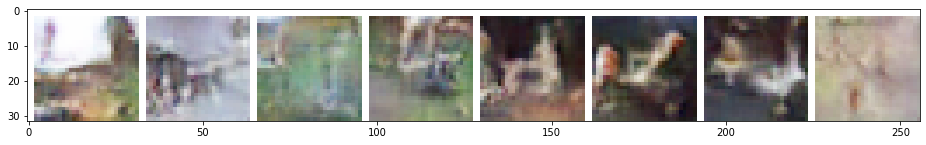

Inception score:   2.246 +-   0.029
step:  1010   time:   3.025  lr: 1.9798000e-04  loss_d:  -1.156  loss_g:   4.390
step:  1020   time:   1.230  lr: 1.9796000e-04  loss_d:  -1.244  loss_g:   1.441
step:  1030   time:   1.239  lr: 1.9794000e-04  loss_d:  -1.262  loss_g:   1.939
step:  1040   time:   1.234  lr: 1.9792000e-04  loss_d:  -1.241  loss_g:   3.014
step:  1050   time:   1.229  lr: 1.9790000e-04  loss_d:  -1.165  loss_g:   2.166
step:  1060   time:   1.239  lr: 1.9788000e-04  loss_d:  -1.287  loss_g:   3.889
step:  1070   time:   1.232  lr: 1.9786000e-04  loss_d:  -1.147  loss_g:   2.777
step:  1080   time:   1.230  lr: 1.9784000e-04  loss_d:  -1.189  loss_g:   5.326
step:  1090   time:   1.256  lr: 1.9782000e-04  loss_d:  -1.159  loss_g:   4.519
step:  1100   time:   1.222  lr: 1.9780000e-04  loss_d:  -1.136  loss_g:   4.176
step:  1110   time:   1.226  lr: 1.9778000e-04  loss_d:  -1.186  loss_g:   0.028
step:  1120   time:   1.229  lr: 1.9776000e-04  loss_d:  -1.102  loss_g: 

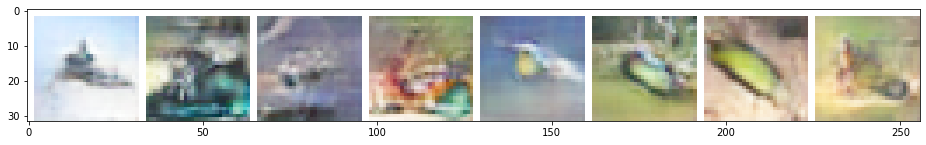

W1230 23:56:01.389446 140151199811392 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Inception score:   2.493 +-   0.029
step:  2010   time:   3.033  lr: 1.9598000e-04  loss_d:  -0.820  loss_g:   2.881
step:  2020   time:   1.225  lr: 1.9596000e-04  loss_d:  -0.854  loss_g:   1.170
step:  2030   time:   1.234  lr: 1.9594000e-04  loss_d:  -0.868  loss_g:   1.988
step:  2040   time:   1.232  lr: 1.9592000e-04  loss_d:  -0.860  loss_g:   2.044
step:  2050   time:   1.222  lr: 1.9590000e-04  loss_d:  -0.884  loss_g:   1.872
step:  2060   time:   1.233  lr: 1.9588000e-04  loss_d:  -0.878  loss_g:   0.320
step:  2070   time:   1.272  lr: 1.9586000e-04  loss_d:  -0.862  loss_g:   2.034
step:  2080   time:   1.221  lr: 1.9584000e-04  loss_d:  -0.859  loss_g:  -0.551
step:  2090   time:   1.231  lr: 1.9582000e-04  loss_d:  -0.803  loss_g:   1.980
step:  2100   time:   1.228  lr: 1.9580000e-04  loss_d:  -0.869  loss_g:   0.532
step:  2110   time:   1.227  lr: 1.9578000e-04  loss_d:  -0.851  loss_g:   0.804
step:  2120   time:   1.229  lr: 1.9576000e-04  loss_d:  -0.884  loss_g: 

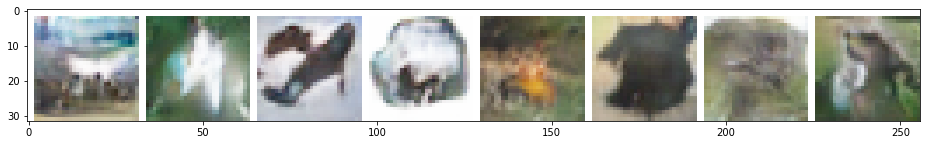

Inception score:   2.592 +-   0.039
step:  3010   time:   3.036  lr: 1.9398000e-04  loss_d:  -0.705  loss_g:   0.708
step:  3020   time:   1.228  lr: 1.9396000e-04  loss_d:  -0.776  loss_g:  -0.068
step:  3030   time:   1.221  lr: 1.9394000e-04  loss_d:  -0.789  loss_g:   1.639
step:  3040   time:   1.230  lr: 1.9392000e-04  loss_d:  -0.763  loss_g:   0.535
step:  3050   time:   1.232  lr: 1.9390000e-04  loss_d:  -0.753  loss_g:   0.096
step:  3060   time:   1.257  lr: 1.9388000e-04  loss_d:  -0.731  loss_g:   0.589
step:  3070   time:   1.240  lr: 1.9386000e-04  loss_d:  -0.747  loss_g:   0.349
step:  3080   time:   1.231  lr: 1.9384000e-04  loss_d:  -0.783  loss_g:   0.138
step:  3090   time:   1.227  lr: 1.9382000e-04  loss_d:  -0.749  loss_g:   1.962
step:  3100   time:   1.238  lr: 1.9380000e-04  loss_d:  -0.727  loss_g:  -0.063
step:  3110   time:   1.238  lr: 1.9378000e-04  loss_d:  -0.781  loss_g:   0.427
step:  3120   time:   1.244  lr: 1.9376000e-04  loss_d:  -0.738  loss_g: 

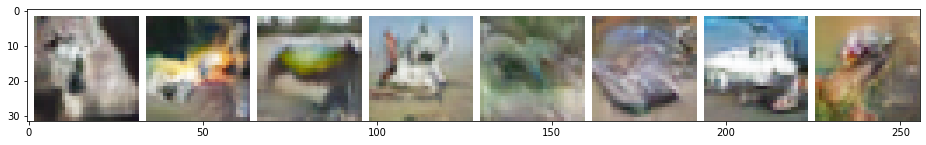

Inception score:   2.653 +-   0.051
step:  4010   time:   3.043  lr: 1.9198000e-04  loss_d:  -0.731  loss_g:   0.088
step:  4020   time:   1.221  lr: 1.9196000e-04  loss_d:  -0.688  loss_g:   0.427
step:  4030   time:   1.224  lr: 1.9194000e-04  loss_d:  -0.727  loss_g:   0.762
step:  4040   time:   1.229  lr: 1.9192000e-04  loss_d:  -0.683  loss_g:   0.112
step:  4050   time:   1.228  lr: 1.9190000e-04  loss_d:  -0.700  loss_g:   1.066
step:  4060   time:   1.232  lr: 1.9188000e-04  loss_d:  -0.715  loss_g:   0.374
step:  4070   time:   1.227  lr: 1.9186000e-04  loss_d:  -0.737  loss_g:   0.391
step:  4080   time:   1.230  lr: 1.9184000e-04  loss_d:  -0.734  loss_g:  -0.513
step:  4090   time:   1.228  lr: 1.9182000e-04  loss_d:  -0.698  loss_g:   0.444
step:  4100   time:   1.230  lr: 1.9180000e-04  loss_d:  -0.703  loss_g:   0.013
step:  4110   time:   1.229  lr: 1.9178000e-04  loss_d:  -0.693  loss_g:  -0.079
step:  4120   time:   1.230  lr: 1.9176000e-04  loss_d:  -0.511  loss_g: 

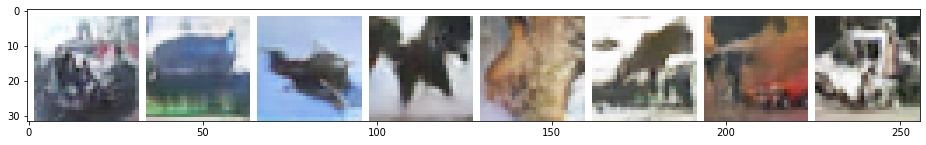

Inception score:   2.714 +-   0.039
step:  5010   time:   3.048  lr: 1.8998000e-04  loss_d:  -0.703  loss_g:   1.299
step:  5020   time:   1.230  lr: 1.8996000e-04  loss_d:  -0.697  loss_g:   0.584
step:  5030   time:   1.234  lr: 1.8994000e-04  loss_d:  -0.689  loss_g:   0.728
step:  5040   time:   1.226  lr: 1.8992000e-04  loss_d:  -0.694  loss_g:   0.916
step:  5050   time:   1.229  lr: 1.8990000e-04  loss_d:  -0.693  loss_g:   0.942
step:  5060   time:   1.228  lr: 1.8988000e-04  loss_d:  -0.670  loss_g:   0.387
step:  5070   time:   1.229  lr: 1.8986000e-04  loss_d:  -0.694  loss_g:   0.329
step:  5080   time:   1.232  lr: 1.8984000e-04  loss_d:  -0.698  loss_g:   0.964
step:  5090   time:   1.226  lr: 1.8982000e-04  loss_d:  -0.672  loss_g:   1.242
step:  5100   time:   1.227  lr: 1.8980000e-04  loss_d:  -0.716  loss_g:   0.376
step:  5110   time:   1.234  lr: 1.8978000e-04  loss_d:  -0.681  loss_g:   0.892
step:  5120   time:   1.231  lr: 1.8976000e-04  loss_d:  -0.720  loss_g: 

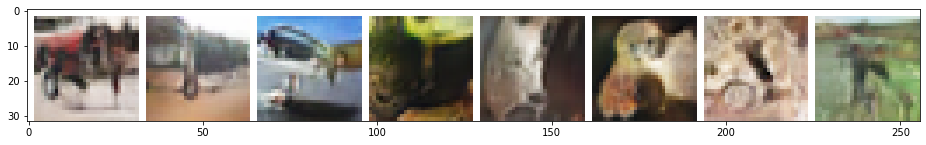

Inception score:   2.938 +-   0.037
step:  6010   time:   3.042  lr: 1.8798000e-04  loss_d:  -0.663  loss_g:   0.789
step:  6020   time:   1.224  lr: 1.8796000e-04  loss_d:  -0.689  loss_g:   0.904
step:  6030   time:   1.225  lr: 1.8794000e-04  loss_d:  -0.668  loss_g:   1.070
step:  6040   time:   1.253  lr: 1.8792000e-04  loss_d:  -0.664  loss_g:   0.436
step:  6050   time:   1.232  lr: 1.8790000e-04  loss_d:  -0.670  loss_g:   1.091
step:  6060   time:   1.219  lr: 1.8788000e-04  loss_d:  -0.659  loss_g:   0.716
step:  6070   time:   1.249  lr: 1.8786000e-04  loss_d:  -0.683  loss_g:   1.267
step:  6080   time:   1.231  lr: 1.8784000e-04  loss_d:  -0.680  loss_g:   1.076
step:  6090   time:   1.226  lr: 1.8782000e-04  loss_d:  -0.665  loss_g:   0.817
step:  6100   time:   1.228  lr: 1.8780000e-04  loss_d:  -0.669  loss_g:   1.181
step:  6110   time:   1.246  lr: 1.8778000e-04  loss_d:  -0.676  loss_g:   0.775
step:  6120   time:   1.255  lr: 1.8776000e-04  loss_d:  -0.646  loss_g: 

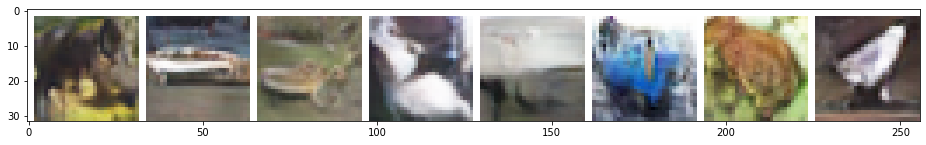

Inception score:   3.015 +-   0.039
step:  7010   time:   3.034  lr: 1.8598000e-04  loss_d:  -0.641  loss_g:   0.900
step:  7020   time:   1.227  lr: 1.8596000e-04  loss_d:  -0.677  loss_g:   0.605
step:  7030   time:   1.231  lr: 1.8594000e-04  loss_d:  -0.653  loss_g:   0.600
step:  7040   time:   1.231  lr: 1.8592000e-04  loss_d:  -0.672  loss_g:   1.452
step:  7050   time:   1.230  lr: 1.8590000e-04  loss_d:  -0.668  loss_g:   1.066
step:  7060   time:   1.226  lr: 1.8588000e-04  loss_d:  -0.667  loss_g:   1.180
step:  7070   time:   1.228  lr: 1.8586000e-04  loss_d:  -0.669  loss_g:   0.511
step:  7080   time:   1.270  lr: 1.8584000e-04  loss_d:  -0.664  loss_g:   1.193
step:  7090   time:   1.227  lr: 1.8582000e-04  loss_d:  -0.670  loss_g:   0.886
step:  7100   time:   1.227  lr: 1.8580000e-04  loss_d:  -0.653  loss_g:   1.025
step:  7110   time:   1.230  lr: 1.8578000e-04  loss_d:  -0.668  loss_g:  -0.040
step:  7120   time:   1.227  lr: 1.8576000e-04  loss_d:  -0.654  loss_g: 

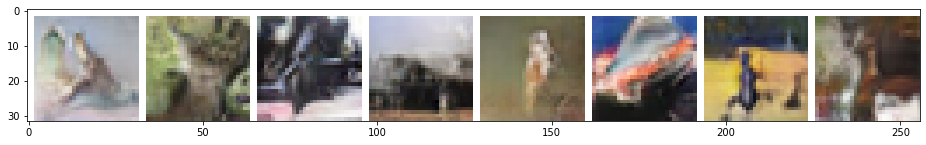

Inception score:   3.150 +-   0.048
step:  8010   time:   3.049  lr: 1.8398000e-04  loss_d:  -0.667  loss_g:   1.868
step:  8020   time:   1.229  lr: 1.8396000e-04  loss_d:  -0.674  loss_g:   1.080
step:  8030   time:   1.233  lr: 1.8394000e-04  loss_d:  -0.661  loss_g:   1.236
step:  8040   time:   1.228  lr: 1.8392000e-04  loss_d:  -0.659  loss_g:   1.461
step:  8050   time:   1.230  lr: 1.8390000e-04  loss_d:  -0.671  loss_g:   0.939
step:  8060   time:   1.228  lr: 1.8388000e-04  loss_d:  -0.655  loss_g:   1.199
step:  8070   time:   1.253  lr: 1.8386000e-04  loss_d:  -0.670  loss_g:   0.989
step:  8080   time:   1.223  lr: 1.8384000e-04  loss_d:  -0.655  loss_g:   0.789
step:  8090   time:   1.231  lr: 1.8382000e-04  loss_d:  -0.674  loss_g:   0.777
step:  8100   time:   1.230  lr: 1.8380000e-04  loss_d:  -0.676  loss_g:   0.880
step:  8110   time:   1.232  lr: 1.8378000e-04  loss_d:  -0.640  loss_g:   1.501
step:  8120   time:   1.223  lr: 1.8376000e-04  loss_d:  -0.654  loss_g: 

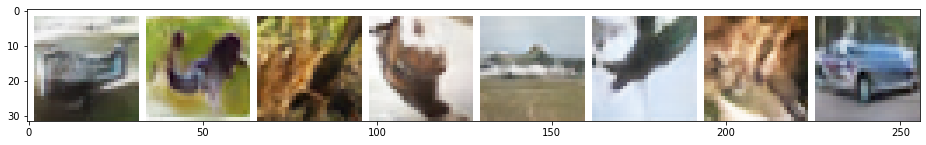

Inception score:   2.910 +-   0.065
step:  9010   time:   3.051  lr: 1.8198000e-04  loss_d:  -0.670  loss_g:   0.719
step:  9020   time:   1.229  lr: 1.8196000e-04  loss_d:  -0.701  loss_g:   2.085
step:  9030   time:   1.230  lr: 1.8194000e-04  loss_d:  -0.665  loss_g:   1.937
step:  9040   time:   1.230  lr: 1.8192000e-04  loss_d:  -0.685  loss_g:   1.760
step:  9050   time:   1.228  lr: 1.8190000e-04  loss_d:  -0.663  loss_g:   1.509
step:  9060   time:   1.232  lr: 1.8188000e-04  loss_d:  -0.649  loss_g:   0.657
step:  9070   time:   1.227  lr: 1.8186000e-04  loss_d:  -0.662  loss_g:   1.284
step:  9080   time:   1.228  lr: 1.8184000e-04  loss_d:  -0.699  loss_g:   0.658
step:  9090   time:   1.229  lr: 1.8182000e-04  loss_d:  -0.678  loss_g:   1.764
step:  9100   time:   1.228  lr: 1.8180000e-04  loss_d:  -0.659  loss_g:   0.752
step:  9110   time:   1.232  lr: 1.8178000e-04  loss_d:  -0.659  loss_g:   2.069
step:  9120   time:   1.266  lr: 1.8176000e-04  loss_d:  -0.667  loss_g: 

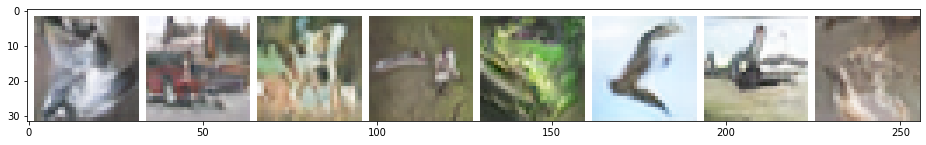

Inception score:   3.234 +-   0.046
step: 10010   time:   3.056  lr: 1.7998000e-04  loss_d:  -0.660  loss_g:   1.950
step: 10020   time:   1.222  lr: 1.7996000e-04  loss_d:  -0.673  loss_g:   1.575
step: 10030   time:   1.232  lr: 1.7994000e-04  loss_d:  -0.699  loss_g:   2.268
step: 10040   time:   1.227  lr: 1.7992000e-04  loss_d:  -0.659  loss_g:   2.020
step: 10050   time:   1.227  lr: 1.7990000e-04  loss_d:  -0.672  loss_g:   2.432
step: 10060   time:   1.228  lr: 1.7988000e-04  loss_d:  -0.659  loss_g:   1.754
step: 10070   time:   1.229  lr: 1.7986000e-04  loss_d:  -0.701  loss_g:   1.496
step: 10080   time:   1.231  lr: 1.7984000e-04  loss_d:  -0.688  loss_g:   1.493
step: 10090   time:   1.228  lr: 1.7982000e-04  loss_d:  -0.682  loss_g:   2.758
step: 10100   time:   1.226  lr: 1.7980000e-04  loss_d:  -0.676  loss_g:   2.033
step: 10110   time:   1.229  lr: 1.7978000e-04  loss_d:  -0.662  loss_g:   1.655
step: 10120   time:   1.229  lr: 1.7976000e-04  loss_d:  -0.686  loss_g: 

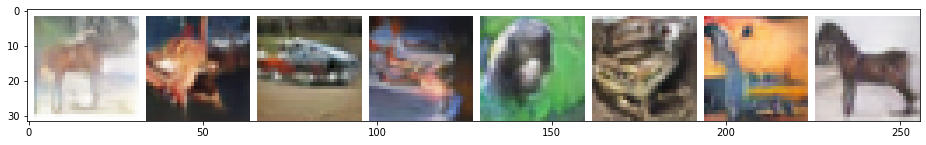

Inception score:   3.027 +-   0.049
step: 11010   time:   3.052  lr: 1.7798000e-04  loss_d:  -0.697  loss_g:   1.595
step: 11020   time:   1.224  lr: 1.7796000e-04  loss_d:  -0.692  loss_g:   2.137
step: 11030   time:   1.228  lr: 1.7794000e-04  loss_d:  -0.718  loss_g:   0.806
step: 11040   time:   1.230  lr: 1.7792000e-04  loss_d:  -0.686  loss_g:   2.180
step: 11050   time:   1.230  lr: 1.7790000e-04  loss_d:  -0.721  loss_g:   2.063
step: 11060   time:   1.232  lr: 1.7788000e-04  loss_d:  -0.680  loss_g:   1.827
step: 11070   time:   1.225  lr: 1.7786000e-04  loss_d:  -0.700  loss_g:   1.976
step: 11080   time:   1.229  lr: 1.7784000e-04  loss_d:  -0.701  loss_g:   1.269
step: 11090   time:   1.231  lr: 1.7782000e-04  loss_d:  -0.700  loss_g:   1.913
step: 11100   time:   1.233  lr: 1.7780000e-04  loss_d:  -0.686  loss_g:   1.003
step: 11110   time:   1.228  lr: 1.7778000e-04  loss_d:  -0.683  loss_g:   2.908
step: 11120   time:   1.225  lr: 1.7776000e-04  loss_d:  -0.717  loss_g: 

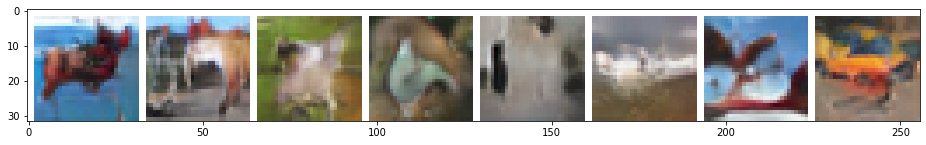

Inception score:   3.194 +-   0.037
step: 12010   time:   3.047  lr: 1.7598000e-04  loss_d:  -0.689  loss_g:   1.751
step: 12020   time:   1.231  lr: 1.7596000e-04  loss_d:  -0.714  loss_g:   1.522
step: 12030   time:   1.226  lr: 1.7594000e-04  loss_d:  -0.677  loss_g:   1.553
step: 12040   time:   1.233  lr: 1.7592000e-04  loss_d:  -0.714  loss_g:   1.483
step: 12050   time:   1.227  lr: 1.7590000e-04  loss_d:  -0.732  loss_g:   1.769
step: 12060   time:   1.230  lr: 1.7588000e-04  loss_d:  -0.731  loss_g:   2.108
step: 12070   time:   1.230  lr: 1.7586000e-04  loss_d:  -0.742  loss_g:   1.534
step: 12080   time:   1.227  lr: 1.7584000e-04  loss_d:  -0.662  loss_g:   1.344
step: 12090   time:   1.227  lr: 1.7582000e-04  loss_d:  -0.712  loss_g:   1.035
step: 12100   time:   1.246  lr: 1.7580000e-04  loss_d:  -0.715  loss_g:   1.421
step: 12110   time:   1.233  lr: 1.7578000e-04  loss_d:  -0.700  loss_g:   1.770
step: 12120   time:   1.231  lr: 1.7576000e-04  loss_d:  -0.698  loss_g: 

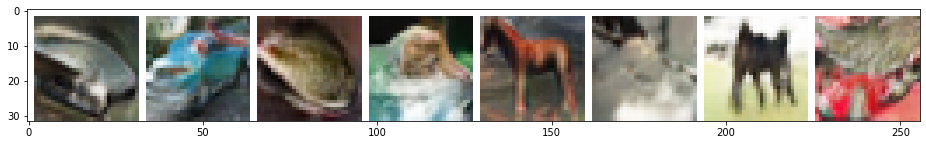

Inception score:   3.158 +-   0.069
step: 13010   time:   3.048  lr: 1.7398000e-04  loss_d:  -0.729  loss_g:   1.311
step: 13020   time:   1.231  lr: 1.7396000e-04  loss_d:  -0.732  loss_g:   0.835
step: 13030   time:   1.231  lr: 1.7394000e-04  loss_d:  -0.739  loss_g:   2.151
step: 13040   time:   1.230  lr: 1.7392000e-04  loss_d:  -0.733  loss_g:   1.037
step: 13050   time:   1.230  lr: 1.7390000e-04  loss_d:  -0.725  loss_g:   1.075
step: 13060   time:   1.225  lr: 1.7388000e-04  loss_d:  -0.708  loss_g:   1.896
step: 13070   time:   1.229  lr: 1.7386000e-04  loss_d:  -0.753  loss_g:   0.895
step: 13080   time:   1.229  lr: 1.7384000e-04  loss_d:  -0.734  loss_g:   0.872
step: 13090   time:   1.259  lr: 1.7382000e-04  loss_d:  -0.739  loss_g:   1.486
step: 13100   time:   1.219  lr: 1.7380000e-04  loss_d:  -0.750  loss_g:   1.286
step: 13110   time:   1.230  lr: 1.7378000e-04  loss_d:  -0.739  loss_g:   1.078
step: 13120   time:   1.232  lr: 1.7376000e-04  loss_d:  -0.727  loss_g: 

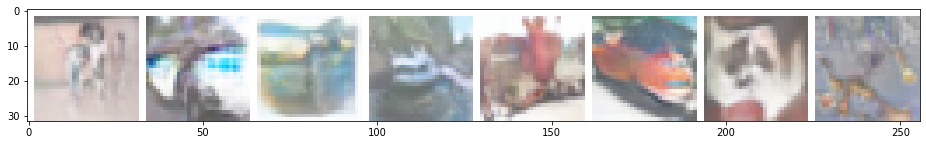

Inception score:   3.202 +-   0.089
step: 14010   time:   3.055  lr: 1.7198000e-04  loss_d:  -0.748  loss_g:   1.715
step: 14020   time:   1.227  lr: 1.7196000e-04  loss_d:  -0.755  loss_g:   1.795
step: 14030   time:   1.236  lr: 1.7194000e-04  loss_d:  -0.745  loss_g:   1.576
step: 14040   time:   1.221  lr: 1.7192000e-04  loss_d:  -0.741  loss_g:   1.339
step: 14050   time:   1.261  lr: 1.7190000e-04  loss_d:  -0.761  loss_g:   1.586
step: 14060   time:   1.237  lr: 1.7188000e-04  loss_d:  -0.721  loss_g:   1.834
step: 14070   time:   1.230  lr: 1.7186000e-04  loss_d:  -0.771  loss_g:   1.518
step: 14080   time:   1.256  lr: 1.7184000e-04  loss_d:  -0.745  loss_g:   1.345
step: 14090   time:   1.222  lr: 1.7182000e-04  loss_d:  -0.749  loss_g:   1.453
step: 14100   time:   1.227  lr: 1.7180000e-04  loss_d:  -0.749  loss_g:   0.947
step: 14110   time:   1.231  lr: 1.7178000e-04  loss_d:  -0.728  loss_g:   1.597
step: 14120   time:   1.226  lr: 1.7176000e-04  loss_d:  -0.745  loss_g: 

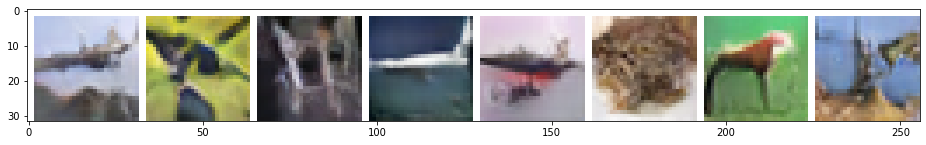

Inception score:   3.397 +-   0.057
step: 15010   time:   3.051  lr: 1.6998000e-04  loss_d:  -0.762  loss_g:   1.747
step: 15020   time:   1.231  lr: 1.6996000e-04  loss_d:  -0.744  loss_g:   1.565
step: 15030   time:   1.231  lr: 1.6994000e-04  loss_d:  -0.807  loss_g:   1.761
step: 15040   time:   1.245  lr: 1.6992000e-04  loss_d:  -0.782  loss_g:   1.271
step: 15050   time:   1.229  lr: 1.6990000e-04  loss_d:  -0.762  loss_g:   2.210
step: 15060   time:   1.230  lr: 1.6988000e-04  loss_d:  -0.758  loss_g:   1.257
step: 15070   time:   1.229  lr: 1.6986000e-04  loss_d:  -0.781  loss_g:   1.789
step: 15080   time:   1.228  lr: 1.6984000e-04  loss_d:  -0.741  loss_g:   0.995
step: 15090   time:   1.232  lr: 1.6982000e-04  loss_d:  -0.761  loss_g:   1.632
step: 15100   time:   1.227  lr: 1.6980000e-04  loss_d:  -0.754  loss_g:   1.371
step: 15110   time:   1.228  lr: 1.6978000e-04  loss_d:  -0.785  loss_g:   1.419
step: 15120   time:   1.227  lr: 1.6976000e-04  loss_d:  -0.785  loss_g: 

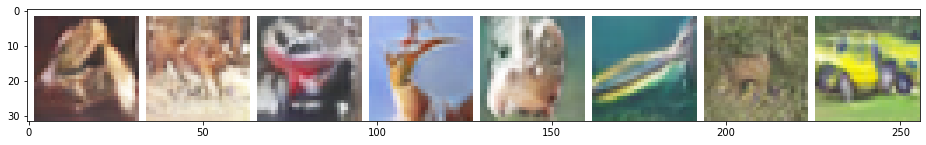

Inception score:   3.322 +-   0.040
step: 16010   time:   3.057  lr: 1.6798000e-04  loss_d:  -0.802  loss_g:   1.840
step: 16020   time:   1.228  lr: 1.6796000e-04  loss_d:  -0.786  loss_g:   1.450
step: 16030   time:   1.231  lr: 1.6794000e-04  loss_d:  -0.809  loss_g:   1.861
step: 16040   time:   1.225  lr: 1.6792000e-04  loss_d:  -0.811  loss_g:   1.445
step: 16050   time:   1.230  lr: 1.6790000e-04  loss_d:  -0.815  loss_g:   1.800
step: 16060   time:   1.231  lr: 1.6788000e-04  loss_d:  -0.791  loss_g:   1.134
step: 16070   time:   1.224  lr: 1.6786000e-04  loss_d:  -0.798  loss_g:   1.552
step: 16080   time:   1.232  lr: 1.6784000e-04  loss_d:  -0.811  loss_g:   1.818
step: 16090   time:   1.227  lr: 1.6782000e-04  loss_d:  -0.822  loss_g:   0.439
step: 16100   time:   1.230  lr: 1.6780000e-04  loss_d:  -0.805  loss_g:   1.176
step: 16110   time:   1.225  lr: 1.6778000e-04  loss_d:  -0.773  loss_g:   1.440
step: 16120   time:   1.231  lr: 1.6776000e-04  loss_d:  -0.796  loss_g: 

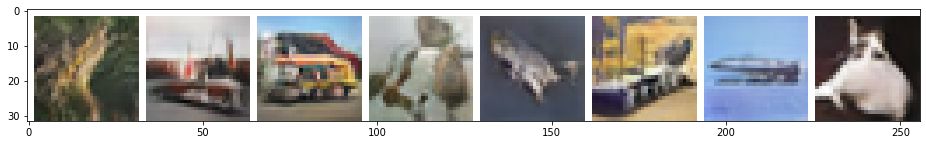

Inception score:   3.275 +-   0.045
step: 17010   time:   3.049  lr: 1.6598000e-04  loss_d:  -0.806  loss_g:   0.818
step: 17020   time:   1.229  lr: 1.6596000e-04  loss_d:  -0.809  loss_g:   1.619
step: 17030   time:   1.229  lr: 1.6594000e-04  loss_d:  -0.802  loss_g:   1.371
step: 17040   time:   1.231  lr: 1.6592000e-04  loss_d:  -0.840  loss_g:   0.566
step: 17050   time:   1.230  lr: 1.6590000e-04  loss_d:  -0.820  loss_g:   2.294
step: 17060   time:   1.229  lr: 1.6588000e-04  loss_d:  -0.807  loss_g:   1.123
step: 17070   time:   1.233  lr: 1.6586000e-04  loss_d:  -0.833  loss_g:   1.461
step: 17080   time:   1.231  lr: 1.6584000e-04  loss_d:  -0.818  loss_g:   1.668
step: 17090   time:   1.226  lr: 1.6582000e-04  loss_d:  -0.819  loss_g:   1.489
step: 17100   time:   1.247  lr: 1.6580000e-04  loss_d:  -0.834  loss_g:   1.903
step: 17110   time:   1.222  lr: 1.6578000e-04  loss_d:  -0.811  loss_g:   2.108
step: 17120   time:   1.232  lr: 1.6576000e-04  loss_d:  -0.829  loss_g: 

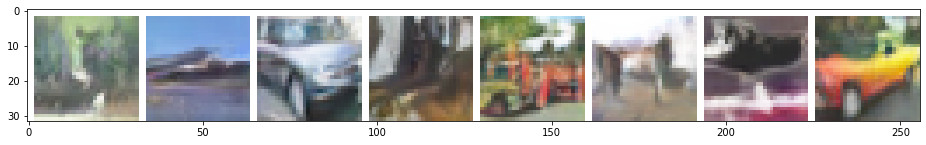

Inception score:   3.213 +-   0.050
step: 18010   time:   3.060  lr: 1.6398000e-04  loss_d:  -0.842  loss_g:   1.712
step: 18020   time:   1.221  lr: 1.6396000e-04  loss_d:  -0.849  loss_g:   1.268
step: 18030   time:   1.230  lr: 1.6394000e-04  loss_d:  -0.844  loss_g:   1.487
step: 18040   time:   1.226  lr: 1.6392000e-04  loss_d:  -0.838  loss_g:   1.502
step: 18050   time:   1.235  lr: 1.6390000e-04  loss_d:  -0.823  loss_g:   0.722
step: 18060   time:   1.226  lr: 1.6388000e-04  loss_d:  -0.845  loss_g:   0.699
step: 18070   time:   1.251  lr: 1.6386000e-04  loss_d:  -0.865  loss_g:   0.926
step: 18080   time:   1.227  lr: 1.6384000e-04  loss_d:  -0.865  loss_g:   1.776
step: 18090   time:   1.230  lr: 1.6382000e-04  loss_d:  -0.834  loss_g:   1.259
step: 18100   time:   1.231  lr: 1.6380000e-04  loss_d:  -0.833  loss_g:   1.616
step: 18110   time:   1.252  lr: 1.6378000e-04  loss_d:  -0.824  loss_g:   2.335
step: 18120   time:   1.227  lr: 1.6376000e-04  loss_d:  -0.856  loss_g: 

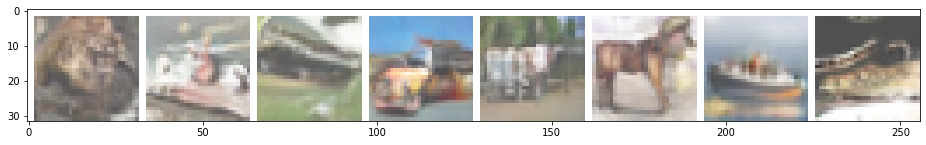

Inception score:   3.266 +-   0.067
step: 19010   time:   3.054  lr: 1.6198000e-04  loss_d:  -0.872  loss_g:   1.970
step: 19020   time:   1.224  lr: 1.6196000e-04  loss_d:  -0.873  loss_g:   0.515
step: 19030   time:   1.232  lr: 1.6194000e-04  loss_d:  -0.846  loss_g:   1.539
step: 19040   time:   1.227  lr: 1.6192000e-04  loss_d:  -0.886  loss_g:   1.794
step: 19050   time:   1.230  lr: 1.6190000e-04  loss_d:  -0.853  loss_g:   1.245
step: 19060   time:   1.263  lr: 1.6188000e-04  loss_d:  -0.887  loss_g:   1.316
step: 19070   time:   1.235  lr: 1.6186000e-04  loss_d:  -0.861  loss_g:   1.407
step: 19080   time:   1.242  lr: 1.6184000e-04  loss_d:  -0.882  loss_g:   1.303
step: 19090   time:   1.237  lr: 1.6182000e-04  loss_d:  -0.903  loss_g:   0.721
step: 19100   time:   1.228  lr: 1.6180000e-04  loss_d:  -0.882  loss_g:   1.104
step: 19110   time:   1.231  lr: 1.6178000e-04  loss_d:  -0.842  loss_g:   2.137
step: 19120   time:   1.225  lr: 1.6176000e-04  loss_d:  -0.872  loss_g: 

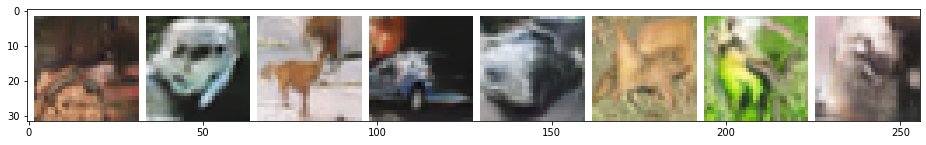

Inception score:   3.396 +-   0.063
step: 20010   time:   3.052  lr: 1.5998000e-04  loss_d:  -0.906  loss_g:   1.781
step: 20020   time:   1.228  lr: 1.5996000e-04  loss_d:  -0.921  loss_g:   1.140
step: 20030   time:   1.231  lr: 1.5994000e-04  loss_d:  -0.908  loss_g:   2.054
step: 20040   time:   1.227  lr: 1.5992000e-04  loss_d:  -0.914  loss_g:   1.541
step: 20050   time:   1.231  lr: 1.5990000e-04  loss_d:  -0.892  loss_g:   1.028
step: 20060   time:   1.228  lr: 1.5988000e-04  loss_d:  -0.877  loss_g:   1.040
step: 20070   time:   1.230  lr: 1.5986000e-04  loss_d:  -0.890  loss_g:   2.331
step: 20080   time:   1.227  lr: 1.5984000e-04  loss_d:  -0.894  loss_g:   1.064
step: 20090   time:   1.239  lr: 1.5982000e-04  loss_d:  -0.880  loss_g:   1.236
step: 20100   time:   1.238  lr: 1.5980000e-04  loss_d:  -0.878  loss_g:   1.022
step: 20110   time:   1.232  lr: 1.5978000e-04  loss_d:  -0.925  loss_g:   1.487
step: 20120   time:   1.227  lr: 1.5976000e-04  loss_d:  -0.885  loss_g: 

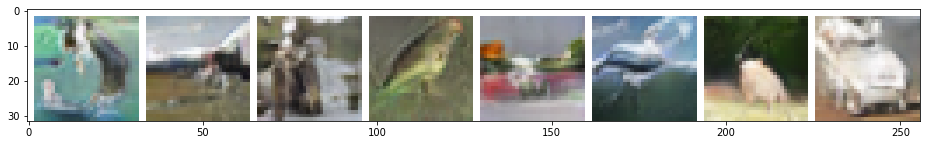

Inception score:   3.263 +-   0.053
step: 21010   time:   3.063  lr: 1.5798000e-04  loss_d:  -0.947  loss_g:   1.822
step: 21020   time:   1.220  lr: 1.5796000e-04  loss_d:  -0.899  loss_g:   1.684
step: 21030   time:   1.226  lr: 1.5794000e-04  loss_d:  -0.935  loss_g:   0.613
step: 21040   time:   1.233  lr: 1.5792000e-04  loss_d:  -0.921  loss_g:   1.210
step: 21050   time:   1.228  lr: 1.5790000e-04  loss_d:  -0.920  loss_g:   1.895
step: 21060   time:   1.226  lr: 1.5788000e-04  loss_d:  -0.912  loss_g:   1.352
step: 21070   time:   1.231  lr: 1.5786000e-04  loss_d:  -0.916  loss_g:   1.500
step: 21080   time:   1.228  lr: 1.5784000e-04  loss_d:  -0.923  loss_g:   1.009
step: 21090   time:   1.230  lr: 1.5782000e-04  loss_d:  -0.936  loss_g:   1.492
step: 21100   time:   1.227  lr: 1.5780000e-04  loss_d:  -0.903  loss_g:   1.992
step: 21110   time:   1.234  lr: 1.5778000e-04  loss_d:  -0.901  loss_g:   2.109
step: 21120   time:   1.225  lr: 1.5776000e-04  loss_d:  -0.947  loss_g: 

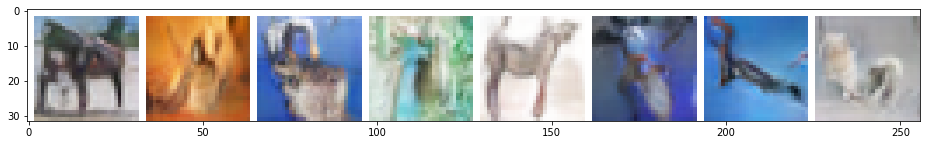

Inception score:   3.298 +-   0.059
step: 22010   time:   3.060  lr: 1.5598000e-04  loss_d:  -0.978  loss_g:   1.396
step: 22020   time:   1.223  lr: 1.5596000e-04  loss_d:  -0.920  loss_g:   1.111
step: 22030   time:   1.227  lr: 1.5594000e-04  loss_d:  -0.925  loss_g:   1.369
step: 22040   time:   1.228  lr: 1.5592000e-04  loss_d:  -0.949  loss_g:   1.166
step: 22050   time:   1.228  lr: 1.5590000e-04  loss_d:  -0.929  loss_g:   1.198
step: 22060   time:   1.230  lr: 1.5588000e-04  loss_d:  -0.937  loss_g:   1.489
step: 22070   time:   1.228  lr: 1.5586000e-04  loss_d:  -0.960  loss_g:   1.236
step: 22080   time:   1.229  lr: 1.5584000e-04  loss_d:  -0.940  loss_g:   1.524
step: 22090   time:   1.229  lr: 1.5582000e-04  loss_d:  -0.930  loss_g:   2.957
step: 22100   time:   1.234  lr: 1.5580000e-04  loss_d:  -0.948  loss_g:   1.017
step: 22110   time:   1.223  lr: 1.5578000e-04  loss_d:  -0.962  loss_g:   1.139
step: 22120   time:   1.233  lr: 1.5576000e-04  loss_d:  -0.958  loss_g: 

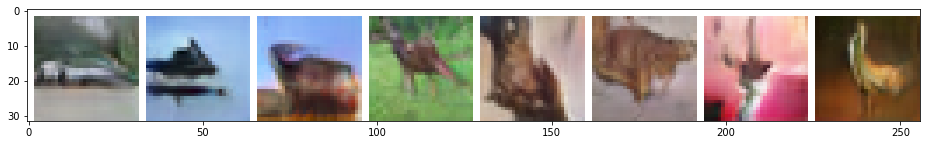

Inception score:   3.394 +-   0.052
step: 23010   time:   3.049  lr: 1.5398000e-04  loss_d:  -0.945  loss_g:   1.803
step: 23020   time:   1.228  lr: 1.5396000e-04  loss_d:  -0.975  loss_g:   1.385
step: 23030   time:   1.227  lr: 1.5394000e-04  loss_d:  -0.943  loss_g:   1.528
step: 23040   time:   1.229  lr: 1.5392000e-04  loss_d:  -0.949  loss_g:   2.436
step: 23050   time:   1.235  lr: 1.5390000e-04  loss_d:  -0.996  loss_g:   0.755
step: 23060   time:   1.222  lr: 1.5388000e-04  loss_d:  -1.013  loss_g:   2.603
step: 23070   time:   1.233  lr: 1.5386000e-04  loss_d:  -0.976  loss_g:   1.486
step: 23080   time:   1.227  lr: 1.5384000e-04  loss_d:  -0.967  loss_g:   1.015
step: 23090   time:   1.230  lr: 1.5382000e-04  loss_d:  -0.969  loss_g:   1.824
step: 23100   time:   1.226  lr: 1.5380000e-04  loss_d:  -0.968  loss_g:   1.547
step: 23110   time:   1.232  lr: 1.5378000e-04  loss_d:  -0.959  loss_g:   1.220
step: 23120   time:   1.235  lr: 1.5376000e-04  loss_d:  -0.983  loss_g: 

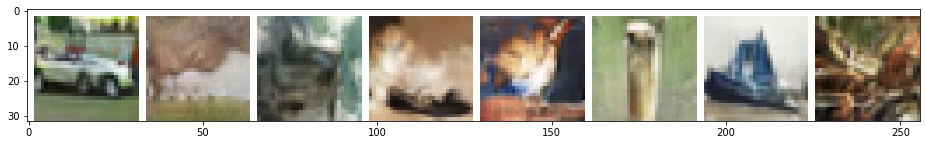

Inception score:   3.425 +-   0.076
step: 24010   time:   3.056  lr: 1.5198000e-04  loss_d:  -1.000  loss_g:   1.088
step: 24020   time:   1.223  lr: 1.5196000e-04  loss_d:  -0.989  loss_g:   2.173
step: 24030   time:   1.225  lr: 1.5194000e-04  loss_d:  -1.003  loss_g:   1.399
step: 24040   time:   1.238  lr: 1.5192000e-04  loss_d:  -1.017  loss_g:   1.249
step: 24050   time:   1.222  lr: 1.5190000e-04  loss_d:  -0.985  loss_g:   1.207
step: 24060   time:   1.228  lr: 1.5188000e-04  loss_d:  -1.026  loss_g:   1.602
step: 24070   time:   1.231  lr: 1.5186000e-04  loss_d:  -1.005  loss_g:   1.123
step: 24080   time:   1.227  lr: 1.5184000e-04  loss_d:  -0.992  loss_g:   2.124
step: 24090   time:   1.228  lr: 1.5182000e-04  loss_d:  -0.985  loss_g:   1.666
step: 24100   time:   1.229  lr: 1.5180000e-04  loss_d:  -0.984  loss_g:   1.644
step: 24110   time:   1.227  lr: 1.5178000e-04  loss_d:  -1.010  loss_g:   1.567
step: 24120   time:   1.231  lr: 1.5176000e-04  loss_d:  -1.006  loss_g: 

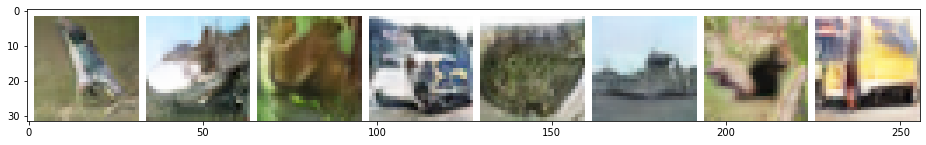

Inception score:   3.314 +-   0.073
step: 25010   time:   3.044  lr: 1.4998000e-04  loss_d:  -1.054  loss_g:   1.293
step: 25020   time:   1.229  lr: 1.4996000e-04  loss_d:  -1.037  loss_g:   1.829
step: 25030   time:   1.231  lr: 1.4994000e-04  loss_d:  -1.015  loss_g:   1.882
step: 25040   time:   1.226  lr: 1.4992000e-04  loss_d:  -1.006  loss_g:   1.576
step: 25050   time:   1.257  lr: 1.4990000e-04  loss_d:  -1.020  loss_g:   1.523
step: 25060   time:   1.222  lr: 1.4988000e-04  loss_d:  -1.020  loss_g:   1.419
step: 25070   time:   1.233  lr: 1.4986000e-04  loss_d:  -1.021  loss_g:   1.614
step: 25080   time:   1.224  lr: 1.4984000e-04  loss_d:  -1.023  loss_g:   1.174
step: 25090   time:   1.229  lr: 1.4982000e-04  loss_d:  -1.039  loss_g:   1.602
step: 25100   time:   1.230  lr: 1.4980000e-04  loss_d:  -0.986  loss_g:   1.709
step: 25110   time:   1.228  lr: 1.4978000e-04  loss_d:  -1.058  loss_g:   1.381
step: 25120   time:   1.230  lr: 1.4976000e-04  loss_d:  -1.032  loss_g: 

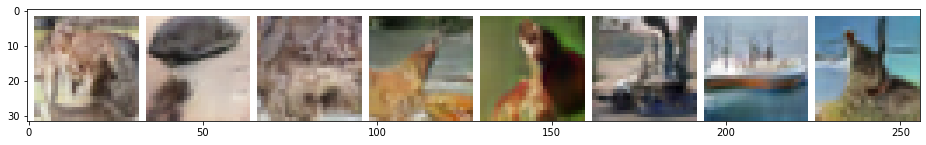

Inception score:   3.341 +-   0.065
step: 26010   time:   3.047  lr: 1.4798000e-04  loss_d:  -0.954  loss_g:   0.756
step: 26020   time:   1.228  lr: 1.4796000e-04  loss_d:  -1.010  loss_g:   0.726
step: 26030   time:   1.232  lr: 1.4794000e-04  loss_d:  -1.048  loss_g:   1.439
step: 26040   time:   1.226  lr: 1.4792000e-04  loss_d:  -1.052  loss_g:   2.002
step: 26050   time:   1.233  lr: 1.4790000e-04  loss_d:  -1.062  loss_g:   1.387
step: 26060   time:   1.227  lr: 1.4788000e-04  loss_d:  -1.026  loss_g:   2.035
step: 26070   time:   1.227  lr: 1.4786000e-04  loss_d:  -1.032  loss_g:   1.688
step: 26080   time:   1.228  lr: 1.4784000e-04  loss_d:  -1.043  loss_g:   2.136
step: 26090   time:   1.233  lr: 1.4782000e-04  loss_d:  -1.051  loss_g:   1.765
step: 26100   time:   1.245  lr: 1.4780000e-04  loss_d:  -1.057  loss_g:   1.475
step: 26110   time:   1.232  lr: 1.4778000e-04  loss_d:  -1.044  loss_g:   1.463
step: 26120   time:   1.229  lr: 1.4776000e-04  loss_d:  -1.025  loss_g: 

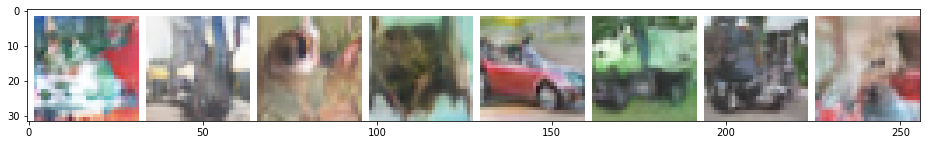

Inception score:   3.388 +-   0.062
step: 27010   time:   3.048  lr: 1.4598000e-04  loss_d:  -1.097  loss_g:   0.720
step: 27020   time:   1.231  lr: 1.4596000e-04  loss_d:  -1.067  loss_g:   2.395
step: 27030   time:   1.234  lr: 1.4594000e-04  loss_d:  -1.048  loss_g:   1.655
step: 27040   time:   1.241  lr: 1.4592000e-04  loss_d:  -1.070  loss_g:   0.820
step: 27050   time:   1.235  lr: 1.4590000e-04  loss_d:  -1.056  loss_g:   1.386
step: 27060   time:   1.230  lr: 1.4588000e-04  loss_d:  -1.077  loss_g:   1.613
step: 27070   time:   1.257  lr: 1.4586000e-04  loss_d:  -0.980  loss_g:   1.508
step: 27080   time:   1.236  lr: 1.4584000e-04  loss_d:  -1.102  loss_g:   1.340
step: 27090   time:   1.230  lr: 1.4582000e-04  loss_d:  -1.076  loss_g:   2.194
step: 27100   time:   1.230  lr: 1.4580000e-04  loss_d:  -1.059  loss_g:   1.842
step: 27110   time:   1.270  lr: 1.4578000e-04  loss_d:  -1.090  loss_g:   1.124
step: 27120   time:   1.227  lr: 1.4576000e-04  loss_d:  -1.091  loss_g: 

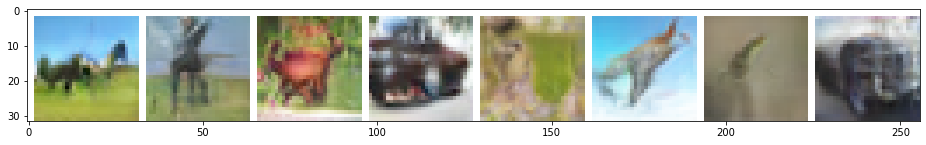

Inception score:   3.290 +-   0.048
step: 28010   time:   3.041  lr: 1.4398000e-04  loss_d:  -1.106  loss_g:   1.600
step: 28020   time:   1.216  lr: 1.4396000e-04  loss_d:  -1.089  loss_g:   1.658
step: 28030   time:   1.228  lr: 1.4394000e-04  loss_d:  -1.107  loss_g:   1.570
step: 28040   time:   1.227  lr: 1.4392000e-04  loss_d:  -1.087  loss_g:   1.927
step: 28050   time:   1.230  lr: 1.4390000e-04  loss_d:  -1.103  loss_g:   1.587
step: 28060   time:   1.230  lr: 1.4388000e-04  loss_d:  -1.100  loss_g:   1.032
step: 28070   time:   1.231  lr: 1.4386000e-04  loss_d:  -1.076  loss_g:   1.330
step: 28080   time:   1.227  lr: 1.4384000e-04  loss_d:  -1.132  loss_g:   1.053
step: 28090   time:   1.229  lr: 1.4382000e-04  loss_d:  -1.105  loss_g:   1.747
step: 28100   time:   1.226  lr: 1.4380000e-04  loss_d:  -1.123  loss_g:   1.613
step: 28110   time:   1.233  lr: 1.4378000e-04  loss_d:  -1.077  loss_g:   2.109
step: 28120   time:   1.252  lr: 1.4376000e-04  loss_d:  -1.099  loss_g: 

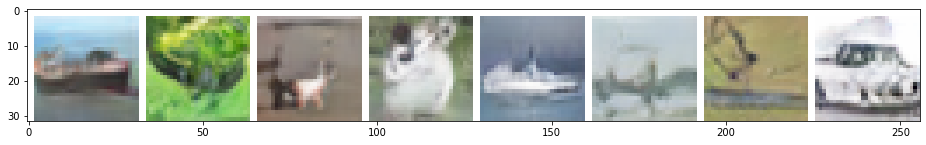

Inception score:   3.399 +-   0.060
step: 29010   time:   3.067  lr: 1.4198000e-04  loss_d:  -1.124  loss_g:   1.247
step: 29020   time:   1.231  lr: 1.4196000e-04  loss_d:  -1.132  loss_g:   1.527
step: 29030   time:   1.233  lr: 1.4194000e-04  loss_d:  -1.123  loss_g:   2.256
step: 29040   time:   1.235  lr: 1.4192000e-04  loss_d:  -1.126  loss_g:   1.113
step: 29050   time:   1.222  lr: 1.4190000e-04  loss_d:  -1.133  loss_g:   1.768
step: 29060   time:   1.257  lr: 1.4188000e-04  loss_d:  -1.116  loss_g:   1.050
step: 29070   time:   1.220  lr: 1.4186000e-04  loss_d:  -1.108  loss_g:   1.522
step: 29080   time:   1.268  lr: 1.4184000e-04  loss_d:  -1.132  loss_g:   1.025
step: 29090   time:   1.235  lr: 1.4182000e-04  loss_d:  -1.116  loss_g:   1.873
step: 29100   time:   1.225  lr: 1.4180000e-04  loss_d:  -1.140  loss_g:   1.533
step: 29110   time:   1.231  lr: 1.4178000e-04  loss_d:  -1.125  loss_g:   1.362
step: 29120   time:   1.228  lr: 1.4176000e-04  loss_d:  -1.112  loss_g: 

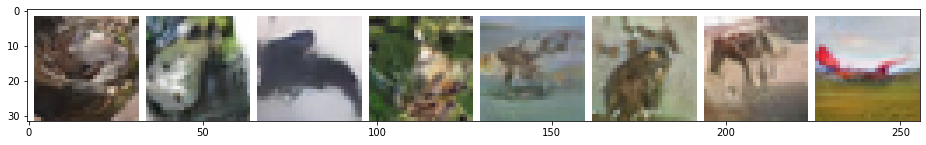

Inception score:   3.456 +-   0.053
step: 30010   time:   3.066  lr: 1.3998000e-04  loss_d:  -1.147  loss_g:   1.571
step: 30020   time:   1.229  lr: 1.3996000e-04  loss_d:  -1.157  loss_g:   1.590
step: 30030   time:   1.233  lr: 1.3994000e-04  loss_d:  -1.173  loss_g:   1.247
step: 30040   time:   1.224  lr: 1.3992000e-04  loss_d:  -1.126  loss_g:   1.968
step: 30050   time:   1.234  lr: 1.3990000e-04  loss_d:  -1.133  loss_g:   2.814
step: 30060   time:   1.225  lr: 1.3988000e-04  loss_d:  -1.163  loss_g:   1.626
step: 30070   time:   1.230  lr: 1.3986000e-04  loss_d:  -1.158  loss_g:   1.364
step: 30080   time:   1.228  lr: 1.3984000e-04  loss_d:  -1.179  loss_g:   1.222
step: 30090   time:   1.229  lr: 1.3982000e-04  loss_d:  -1.157  loss_g:   1.507
step: 30100   time:   1.229  lr: 1.3980000e-04  loss_d:  -1.167  loss_g:   2.129
step: 30110   time:   1.236  lr: 1.3978000e-04  loss_d:  -1.171  loss_g:   1.939
step: 30120   time:   1.221  lr: 1.3976000e-04  loss_d:  -1.148  loss_g: 

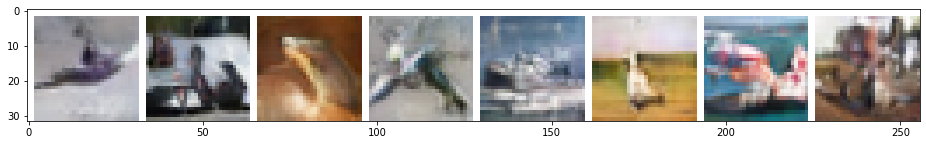

Inception score:   3.408 +-   0.073
step: 31010   time:   3.065  lr: 1.3798000e-04  loss_d:  -1.210  loss_g:   1.882
step: 31020   time:   1.216  lr: 1.3796000e-04  loss_d:  -1.155  loss_g:   0.975
step: 31030   time:   1.229  lr: 1.3794000e-04  loss_d:  -1.183  loss_g:   1.350
step: 31040   time:   1.232  lr: 1.3792000e-04  loss_d:  -1.191  loss_g:   1.924
step: 31050   time:   1.227  lr: 1.3790000e-04  loss_d:  -1.190  loss_g:   1.675
step: 31060   time:   1.229  lr: 1.3788000e-04  loss_d:  -1.176  loss_g:   1.862
step: 31070   time:   1.227  lr: 1.3786000e-04  loss_d:  -1.187  loss_g:   2.060
step: 31080   time:   1.228  lr: 1.3784000e-04  loss_d:  -1.190  loss_g:   2.038
step: 31090   time:   1.229  lr: 1.3782000e-04  loss_d:  -1.175  loss_g:   1.278
step: 31100   time:   1.231  lr: 1.3780000e-04  loss_d:  -1.193  loss_g:   1.843
step: 31110   time:   1.228  lr: 1.3778000e-04  loss_d:  -1.170  loss_g:   1.483
step: 31120   time:   1.256  lr: 1.3776000e-04  loss_d:  -1.200  loss_g: 

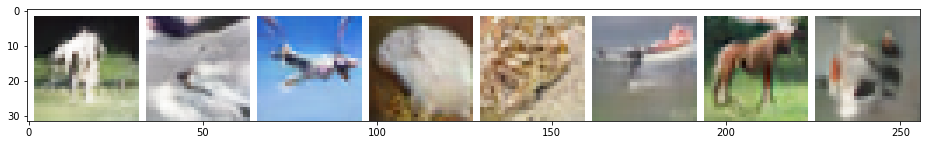

Inception score:   3.365 +-   0.035
step: 32010   time:   3.067  lr: 1.3598000e-04  loss_d:  -1.208  loss_g:   1.405
step: 32020   time:   1.231  lr: 1.3596000e-04  loss_d:  -1.209  loss_g:   2.213
step: 32030   time:   1.231  lr: 1.3594000e-04  loss_d:  -1.218  loss_g:   1.070
step: 32040   time:   1.231  lr: 1.3592000e-04  loss_d:  -1.206  loss_g:   1.050
step: 32050   time:   1.229  lr: 1.3590000e-04  loss_d:  -1.190  loss_g:   0.889
step: 32060   time:   1.229  lr: 1.3588000e-04  loss_d:  -1.215  loss_g:   1.541
step: 32070   time:   1.272  lr: 1.3586000e-04  loss_d:  -1.192  loss_g:   1.760
step: 32080   time:   1.231  lr: 1.3584000e-04  loss_d:  -1.205  loss_g:   1.209
step: 32090   time:   1.230  lr: 1.3582000e-04  loss_d:  -1.209  loss_g:   1.820
step: 32100   time:   1.227  lr: 1.3580000e-04  loss_d:  -1.195  loss_g:   1.163
step: 32110   time:   1.223  lr: 1.3578000e-04  loss_d:  -1.233  loss_g:   1.505
step: 32120   time:   1.230  lr: 1.3576000e-04  loss_d:  -1.193  loss_g: 

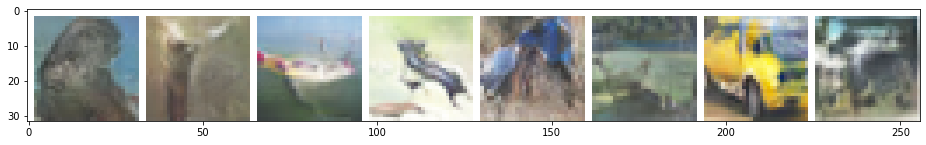

Inception score:   3.470 +-   0.063
step: 33010   time:   3.059  lr: 1.3398000e-04  loss_d:  -1.247  loss_g:   2.104
step: 33020   time:   1.225  lr: 1.3396000e-04  loss_d:  -1.250  loss_g:   2.201
step: 33030   time:   1.225  lr: 1.3394000e-04  loss_d:  -1.231  loss_g:   1.725
step: 33040   time:   1.228  lr: 1.3392000e-04  loss_d:  -1.203  loss_g:   1.805
step: 33050   time:   1.232  lr: 1.3390000e-04  loss_d:  -1.205  loss_g:   1.977
step: 33060   time:   1.227  lr: 1.3388000e-04  loss_d:  -1.256  loss_g:   0.722
step: 33070   time:   1.230  lr: 1.3386000e-04  loss_d:  -1.244  loss_g:   2.009
step: 33080   time:   1.230  lr: 1.3384000e-04  loss_d:  -1.201  loss_g:   1.965
step: 33090   time:   1.226  lr: 1.3382000e-04  loss_d:  -1.249  loss_g:   0.977
step: 33100   time:   1.231  lr: 1.3380000e-04  loss_d:  -1.266  loss_g:   1.973
step: 33110   time:   1.227  lr: 1.3378000e-04  loss_d:  -1.220  loss_g:   1.715
step: 33120   time:   1.230  lr: 1.3376000e-04  loss_d:  -1.230  loss_g: 

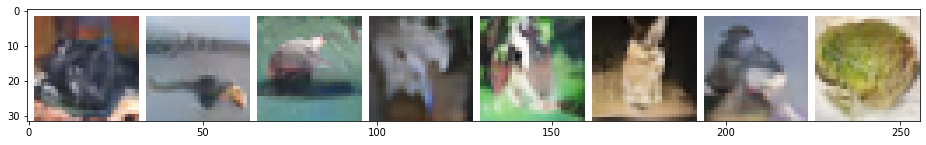

Inception score:   3.427 +-   0.065
step: 34010   time:   3.063  lr: 1.3198000e-04  loss_d:  -1.261  loss_g:   2.124
step: 34020   time:   1.213  lr: 1.3196000e-04  loss_d:  -1.271  loss_g:   2.063
step: 34030   time:   1.235  lr: 1.3194000e-04  loss_d:  -1.253  loss_g:   2.076
step: 34040   time:   1.225  lr: 1.3192000e-04  loss_d:  -1.273  loss_g:   1.261
step: 34050   time:   1.229  lr: 1.3190000e-04  loss_d:  -1.243  loss_g:   1.997
step: 34060   time:   1.229  lr: 1.3188000e-04  loss_d:  -1.224  loss_g:   1.411
step: 34070   time:   1.228  lr: 1.3186000e-04  loss_d:  -1.272  loss_g:   1.420
step: 34080   time:   1.232  lr: 1.3184000e-04  loss_d:  -1.260  loss_g:   1.573
step: 34090   time:   1.227  lr: 1.3182000e-04  loss_d:  -1.285  loss_g:   1.294
step: 34100   time:   1.228  lr: 1.3180000e-04  loss_d:  -1.258  loss_g:   1.805
step: 34110   time:   1.229  lr: 1.3178000e-04  loss_d:  -1.236  loss_g:   1.915
step: 34120   time:   1.227  lr: 1.3176000e-04  loss_d:  -1.262  loss_g: 

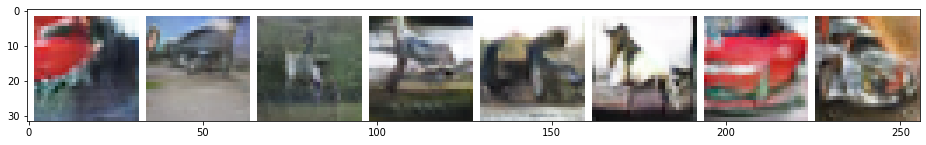

Inception score:   3.411 +-   0.049
step: 35010   time:   3.070  lr: 1.2998000e-04  loss_d:  -1.311  loss_g:   1.595
step: 35020   time:   1.229  lr: 1.2996000e-04  loss_d:  -1.265  loss_g:   1.847
step: 35030   time:   1.241  lr: 1.2994000e-04  loss_d:  -1.308  loss_g:   1.494
step: 35040   time:   1.245  lr: 1.2992000e-04  loss_d:  -1.266  loss_g:   1.917
step: 35050   time:   1.223  lr: 1.2990000e-04  loss_d:  -1.289  loss_g:   1.670
step: 35060   time:   1.225  lr: 1.2988000e-04  loss_d:  -1.250  loss_g:   2.583
step: 35070   time:   1.228  lr: 1.2986000e-04  loss_d:  -1.273  loss_g:   1.558
step: 35080   time:   1.276  lr: 1.2984000e-04  loss_d:  -1.273  loss_g:   1.352
step: 35090   time:   1.226  lr: 1.2982000e-04  loss_d:  -1.287  loss_g:   1.759
step: 35100   time:   1.227  lr: 1.2980000e-04  loss_d:  -1.263  loss_g:   1.648
step: 35110   time:   1.231  lr: 1.2978000e-04  loss_d:  -1.279  loss_g:   2.183
step: 35120   time:   1.271  lr: 1.2976000e-04  loss_d:  -1.286  loss_g: 

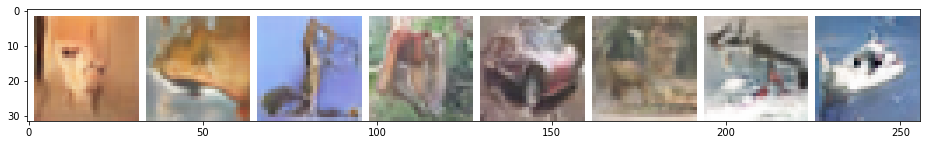

Inception score:   3.361 +-   0.066
step: 36010   time:   3.069  lr: 1.2798000e-04  loss_d:  -1.303  loss_g:   1.911
step: 36020   time:   1.216  lr: 1.2796000e-04  loss_d:  -1.333  loss_g:   1.609
step: 36030   time:   1.232  lr: 1.2794000e-04  loss_d:  -1.317  loss_g:   1.208
step: 36040   time:   1.219  lr: 1.2792000e-04  loss_d:  -1.327  loss_g:   1.924
step: 36050   time:   1.231  lr: 1.2790000e-04  loss_d:  -1.295  loss_g:   2.179
step: 36060   time:   1.228  lr: 1.2788000e-04  loss_d:  -1.315  loss_g:   1.281
step: 36070   time:   1.228  lr: 1.2786000e-04  loss_d:  -1.299  loss_g:   2.057
step: 36080   time:   1.235  lr: 1.2784000e-04  loss_d:  -1.318  loss_g:   1.212
step: 36090   time:   1.225  lr: 1.2782000e-04  loss_d:  -1.288  loss_g:   1.892
step: 36100   time:   1.229  lr: 1.2780000e-04  loss_d:  -1.301  loss_g:   1.382
step: 36110   time:   1.229  lr: 1.2778000e-04  loss_d:  -1.324  loss_g:   1.552
step: 36120   time:   1.227  lr: 1.2776000e-04  loss_d:  -1.299  loss_g: 

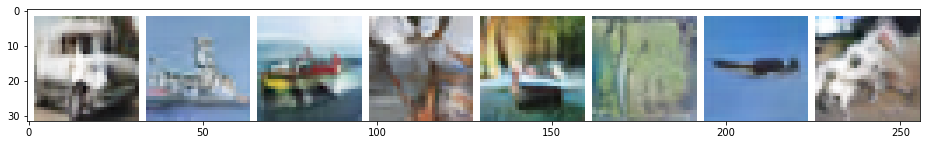

Inception score:   3.427 +-   0.052
step: 37010   time:   3.069  lr: 1.2598000e-04  loss_d:  -1.342  loss_g:   2.169
step: 37020   time:   1.230  lr: 1.2596000e-04  loss_d:  -1.340  loss_g:   1.450
step: 37030   time:   1.232  lr: 1.2594000e-04  loss_d:  -1.342  loss_g:   1.725
step: 37040   time:   1.232  lr: 1.2592000e-04  loss_d:  -1.318  loss_g:   1.281
step: 37050   time:   1.225  lr: 1.2590000e-04  loss_d:  -1.323  loss_g:   1.645
step: 37060   time:   1.235  lr: 1.2588000e-04  loss_d:  -1.343  loss_g:   1.519
step: 37070   time:   1.221  lr: 1.2586000e-04  loss_d:  -1.341  loss_g:   1.667
step: 37080   time:   1.228  lr: 1.2584000e-04  loss_d:  -1.339  loss_g:   1.841
step: 37090   time:   1.230  lr: 1.2582000e-04  loss_d:  -1.330  loss_g:   1.773
step: 37100   time:   1.232  lr: 1.2580000e-04  loss_d:  -1.343  loss_g:   1.451
step: 37110   time:   1.238  lr: 1.2578000e-04  loss_d:  -1.329  loss_g:   1.341
step: 37120   time:   1.235  lr: 1.2576000e-04  loss_d:  -1.340  loss_g: 

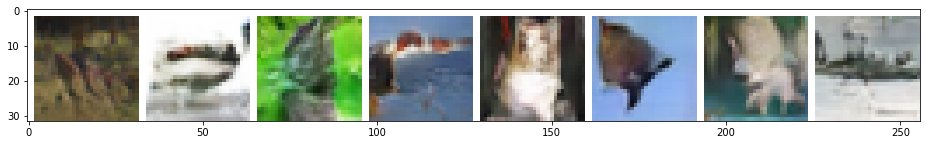

Inception score:   3.449 +-   0.081
step: 38010   time:   3.070  lr: 1.2398000e-04  loss_d:  -1.357  loss_g:   1.668
step: 38020   time:   1.231  lr: 1.2396000e-04  loss_d:  -1.369  loss_g:   2.511
step: 38030   time:   1.231  lr: 1.2394000e-04  loss_d:  -1.352  loss_g:   1.996
step: 38040   time:   1.228  lr: 1.2392000e-04  loss_d:  -1.360  loss_g:   1.651
step: 38050   time:   1.228  lr: 1.2390000e-04  loss_d:  -1.340  loss_g:   1.803
step: 38060   time:   1.228  lr: 1.2388000e-04  loss_d:  -1.349  loss_g:   1.400
step: 38070   time:   1.232  lr: 1.2386000e-04  loss_d:  -1.341  loss_g:   1.830
step: 38080   time:   1.225  lr: 1.2384000e-04  loss_d:  -1.364  loss_g:   1.616
step: 38090   time:   1.231  lr: 1.2382000e-04  loss_d:  -1.343  loss_g:   2.462
step: 38100   time:   1.228  lr: 1.2380000e-04  loss_d:  -1.359  loss_g:   2.324
step: 38110   time:   1.228  lr: 1.2378000e-04  loss_d:  -1.379  loss_g:   2.190
step: 38120   time:   1.231  lr: 1.2376000e-04  loss_d:  -1.356  loss_g: 

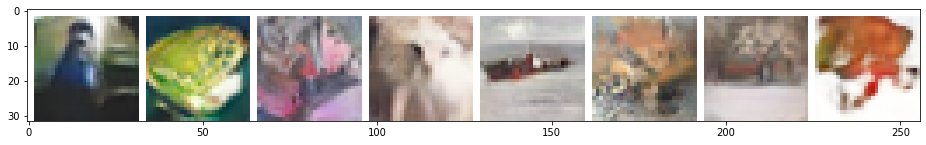

Inception score:   3.490 +-   0.047
step: 39010   time:   3.070  lr: 1.2198000e-04  loss_d:  -1.378  loss_g:   1.886
step: 39020   time:   1.226  lr: 1.2196000e-04  loss_d:  -1.389  loss_g:   2.203
step: 39030   time:   1.234  lr: 1.2194000e-04  loss_d:  -1.376  loss_g:   2.142
step: 39040   time:   1.229  lr: 1.2192000e-04  loss_d:  -1.392  loss_g:   2.246
step: 39050   time:   1.234  lr: 1.2190000e-04  loss_d:  -1.373  loss_g:   2.527
step: 39060   time:   1.225  lr: 1.2188000e-04  loss_d:  -1.374  loss_g:   1.158
step: 39070   time:   1.229  lr: 1.2186000e-04  loss_d:  -1.375  loss_g:   1.985
step: 39080   time:   1.230  lr: 1.2184000e-04  loss_d:  -1.386  loss_g:   1.888
step: 39090   time:   1.228  lr: 1.2182000e-04  loss_d:  -1.379  loss_g:   2.190
step: 39100   time:   1.231  lr: 1.2180000e-04  loss_d:  -1.409  loss_g:   1.618
step: 39110   time:   1.229  lr: 1.2178000e-04  loss_d:  -1.353  loss_g:   2.655
step: 39120   time:   1.249  lr: 1.2176000e-04  loss_d:  -1.403  loss_g: 

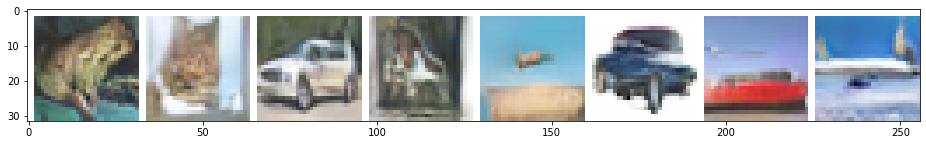

Inception score:   3.483 +-   0.080
step: 40010   time:   3.069  lr: 1.1998000e-04  loss_d:  -1.419  loss_g:   1.506
step: 40020   time:   1.227  lr: 1.1996000e-04  loss_d:  -1.387  loss_g:   2.114
step: 40030   time:   1.237  lr: 1.1994000e-04  loss_d:  -1.393  loss_g:   1.812
step: 40040   time:   1.225  lr: 1.1992000e-04  loss_d:  -1.435  loss_g:   2.594
step: 40050   time:   1.230  lr: 1.1990000e-04  loss_d:  -1.398  loss_g:   2.966
step: 40060   time:   1.228  lr: 1.1988000e-04  loss_d:  -1.395  loss_g:   1.003
step: 40070   time:   1.229  lr: 1.1986000e-04  loss_d:  -1.405  loss_g:   2.332
step: 40080   time:   1.230  lr: 1.1984000e-04  loss_d:  -1.381  loss_g:   1.767
step: 40090   time:   1.228  lr: 1.1982000e-04  loss_d:  -1.403  loss_g:   1.564
step: 40100   time:   1.228  lr: 1.1980000e-04  loss_d:  -1.416  loss_g:   2.339
step: 40110   time:   1.229  lr: 1.1978000e-04  loss_d:  -1.441  loss_g:   2.327
step: 40120   time:   1.230  lr: 1.1976000e-04  loss_d:  -1.383  loss_g: 

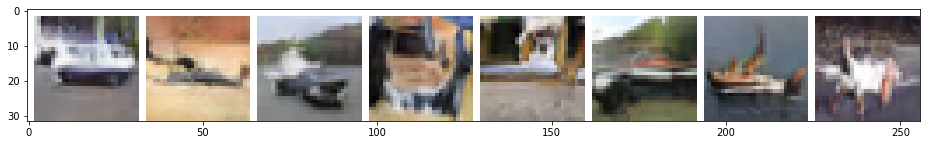

Inception score:   3.433 +-   0.090
step: 41010   time:   3.050  lr: 1.1798000e-04  loss_d:  -1.410  loss_g:   2.672
step: 41020   time:   1.231  lr: 1.1796000e-04  loss_d:  -1.432  loss_g:   1.382
step: 41030   time:   1.237  lr: 1.1794000e-04  loss_d:  -1.445  loss_g:   1.672
step: 41040   time:   1.222  lr: 1.1792000e-04  loss_d:  -1.391  loss_g:   2.040
step: 41050   time:   1.230  lr: 1.1790000e-04  loss_d:  -1.432  loss_g:   1.558
step: 41060   time:   1.227  lr: 1.1788000e-04  loss_d:  -1.431  loss_g:   2.667
step: 41070   time:   1.256  lr: 1.1786000e-04  loss_d:  -1.391  loss_g:   1.642
step: 41080   time:   1.231  lr: 1.1784000e-04  loss_d:  -1.448  loss_g:   2.052
step: 41090   time:   1.231  lr: 1.1782000e-04  loss_d:  -1.414  loss_g:   1.699
step: 41100   time:   1.266  lr: 1.1780000e-04  loss_d:  -1.425  loss_g:   2.382
step: 41110   time:   1.221  lr: 1.1778000e-04  loss_d:  -1.449  loss_g:   1.730
step: 41120   time:   1.231  lr: 1.1776000e-04  loss_d:  -1.396  loss_g: 

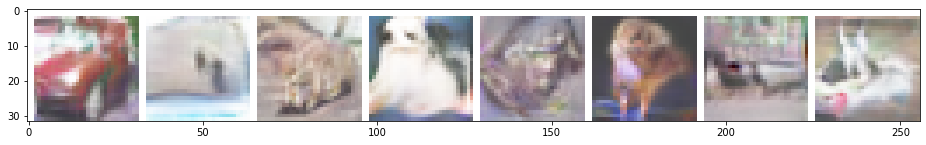

Inception score:   3.432 +-   0.064
step: 42010   time:   3.072  lr: 1.1598000e-04  loss_d:  -1.433  loss_g:   2.558
step: 42020   time:   1.234  lr: 1.1596000e-04  loss_d:  -1.406  loss_g:   1.426
step: 42030   time:   1.224  lr: 1.1594000e-04  loss_d:  -1.452  loss_g:   1.361
step: 42040   time:   1.229  lr: 1.1592000e-04  loss_d:  -1.467  loss_g:   1.508
step: 42050   time:   1.271  lr: 1.1590000e-04  loss_d:  -1.437  loss_g:   2.025
step: 42060   time:   1.232  lr: 1.1588000e-04  loss_d:  -1.450  loss_g:   2.018
step: 42070   time:   1.252  lr: 1.1586000e-04  loss_d:  -1.446  loss_g:   2.207
step: 42080   time:   1.246  lr: 1.1584000e-04  loss_d:  -1.436  loss_g:   3.056
step: 42090   time:   1.228  lr: 1.1582000e-04  loss_d:  -1.448  loss_g:   2.135
step: 42100   time:   1.228  lr: 1.1580000e-04  loss_d:  -1.434  loss_g:   2.284
step: 42110   time:   1.230  lr: 1.1578000e-04  loss_d:  -1.448  loss_g:   1.653
step: 42120   time:   1.230  lr: 1.1576000e-04  loss_d:  -1.458  loss_g: 

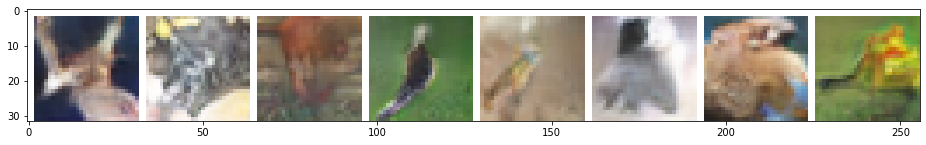

Inception score:   3.454 +-   0.074
step: 43010   time:   3.031  lr: 1.1398000e-04  loss_d:  -1.458  loss_g:   3.310
step: 43020   time:   1.227  lr: 1.1396000e-04  loss_d:  -1.459  loss_g:   2.232
step: 43030   time:   1.229  lr: 1.1394000e-04  loss_d:  -1.475  loss_g:   2.014
step: 43040   time:   1.230  lr: 1.1392000e-04  loss_d:  -1.477  loss_g:   2.753
step: 43050   time:   1.233  lr: 1.1390000e-04  loss_d:  -1.433  loss_g:   1.130
step: 43060   time:   1.223  lr: 1.1388000e-04  loss_d:  -1.472  loss_g:   2.507
step: 43070   time:   1.250  lr: 1.1386000e-04  loss_d:  -1.476  loss_g:   1.798
step: 43080   time:   1.228  lr: 1.1384000e-04  loss_d:  -1.437  loss_g:   2.666
step: 43090   time:   1.231  lr: 1.1382000e-04  loss_d:  -1.472  loss_g:   3.199
step: 43100   time:   1.229  lr: 1.1380000e-04  loss_d:  -1.471  loss_g:   1.754
step: 43110   time:   1.229  lr: 1.1378000e-04  loss_d:  -1.472  loss_g:   3.006
step: 43120   time:   1.228  lr: 1.1376000e-04  loss_d:  -1.456  loss_g: 

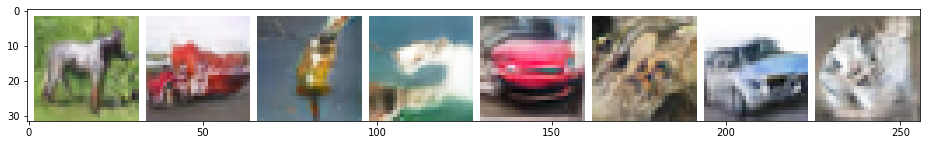

Inception score:   3.436 +-   0.059
step: 44010   time:   3.038  lr: 1.1198000e-04  loss_d:  -1.482  loss_g:   2.146
step: 44020   time:   1.224  lr: 1.1196000e-04  loss_d:  -1.493  loss_g:   2.211
step: 44030   time:   1.227  lr: 1.1194000e-04  loss_d:  -1.470  loss_g:   2.326
step: 44040   time:   1.229  lr: 1.1192000e-04  loss_d:  -1.495  loss_g:   2.195
step: 44050   time:   1.232  lr: 1.1190000e-04  loss_d:  -1.477  loss_g:   1.684
step: 44060   time:   1.228  lr: 1.1188000e-04  loss_d:  -1.482  loss_g:   3.022
step: 44070   time:   1.230  lr: 1.1186000e-04  loss_d:  -1.493  loss_g:   1.433
step: 44080   time:   1.226  lr: 1.1184000e-04  loss_d:  -1.475  loss_g:   1.827
step: 44090   time:   1.237  lr: 1.1182000e-04  loss_d:  -1.485  loss_g:   2.282
step: 44100   time:   1.262  lr: 1.1180000e-04  loss_d:  -1.503  loss_g:   2.335
step: 44110   time:   1.228  lr: 1.1178000e-04  loss_d:  -1.490  loss_g:   1.908
step: 44120   time:   1.249  lr: 1.1176000e-04  loss_d:  -1.485  loss_g: 

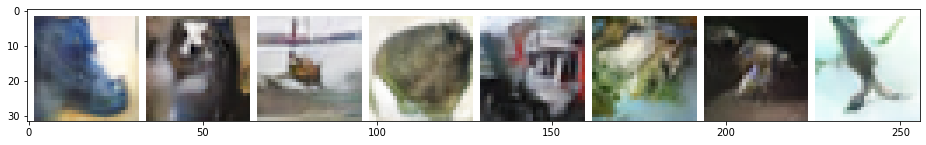

Inception score:   3.414 +-   0.053
step: 45010   time:   3.063  lr: 1.0998000e-04  loss_d:  -1.510  loss_g:   1.703
step: 45020   time:   1.224  lr: 1.0996000e-04  loss_d:  -1.498  loss_g:   2.070
step: 45030   time:   1.222  lr: 1.0994000e-04  loss_d:  -1.508  loss_g:   2.580
step: 45040   time:   1.230  lr: 1.0992000e-04  loss_d:  -1.493  loss_g:   2.243
step: 45050   time:   1.259  lr: 1.0990000e-04  loss_d:  -1.533  loss_g:   2.396
step: 45060   time:   1.219  lr: 1.0988000e-04  loss_d:  -1.509  loss_g:   2.187
step: 45070   time:   1.240  lr: 1.0986000e-04  loss_d:  -1.502  loss_g:   2.271
step: 45080   time:   1.239  lr: 1.0984000e-04  loss_d:  -1.492  loss_g:   2.690
step: 45090   time:   1.234  lr: 1.0982000e-04  loss_d:  -1.522  loss_g:   2.003
step: 45100   time:   1.226  lr: 1.0980000e-04  loss_d:  -1.516  loss_g:   1.736
step: 45110   time:   1.227  lr: 1.0978000e-04  loss_d:  -1.511  loss_g:   2.786
step: 45120   time:   1.230  lr: 1.0976000e-04  loss_d:  -1.493  loss_g: 

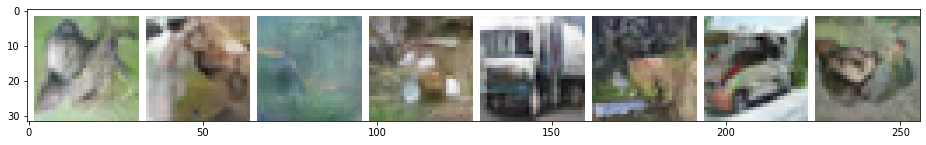

Inception score:   3.375 +-   0.040
step: 46010   time:   3.054  lr: 1.0798000e-04  loss_d:  -1.531  loss_g:   2.153
step: 46020   time:   1.224  lr: 1.0796000e-04  loss_d:  -1.516  loss_g:   1.968
step: 46030   time:   1.234  lr: 1.0794000e-04  loss_d:  -1.548  loss_g:   2.450
step: 46040   time:   1.243  lr: 1.0792000e-04  loss_d:  -1.531  loss_g:   2.130
step: 46050   time:   1.231  lr: 1.0790000e-04  loss_d:  -1.540  loss_g:   2.310
step: 46060   time:   1.231  lr: 1.0788000e-04  loss_d:  -1.528  loss_g:   2.050
step: 46070   time:   1.225  lr: 1.0786000e-04  loss_d:  -1.535  loss_g:   2.431
step: 46080   time:   1.228  lr: 1.0784000e-04  loss_d:  -1.532  loss_g:   1.978
step: 46090   time:   1.229  lr: 1.0782000e-04  loss_d:  -1.509  loss_g:   1.993
step: 46100   time:   1.258  lr: 1.0780000e-04  loss_d:  -1.537  loss_g:   2.307
step: 46110   time:   1.240  lr: 1.0778000e-04  loss_d:  -1.537  loss_g:   1.918
step: 46120   time:   1.229  lr: 1.0776000e-04  loss_d:  -1.546  loss_g: 

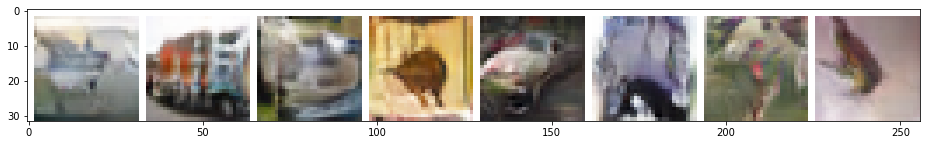

Inception score:   3.394 +-   0.058
step: 47010   time:   3.050  lr: 1.0598000e-04  loss_d:  -1.547  loss_g:   2.350
step: 47020   time:   1.228  lr: 1.0596000e-04  loss_d:  -1.542  loss_g:   2.425
step: 47030   time:   1.226  lr: 1.0594000e-04  loss_d:  -1.557  loss_g:   1.716
step: 47040   time:   1.233  lr: 1.0592000e-04  loss_d:  -1.541  loss_g:   1.865
step: 47050   time:   1.228  lr: 1.0590000e-04  loss_d:  -1.542  loss_g:   1.781
step: 47060   time:   1.226  lr: 1.0588000e-04  loss_d:  -1.533  loss_g:   2.579
step: 47070   time:   1.230  lr: 1.0586000e-04  loss_d:  -1.594  loss_g:   2.497
step: 47080   time:   1.228  lr: 1.0584000e-04  loss_d:  -1.547  loss_g:   2.248
step: 47090   time:   1.228  lr: 1.0582000e-04  loss_d:  -1.542  loss_g:   2.313
step: 47100   time:   1.268  lr: 1.0580000e-04  loss_d:  -1.538  loss_g:   2.128
step: 47110   time:   1.238  lr: 1.0578000e-04  loss_d:  -1.563  loss_g:   2.185
step: 47120   time:   1.224  lr: 1.0576000e-04  loss_d:  -1.548  loss_g: 

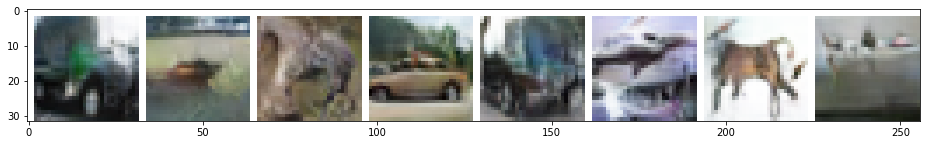

Inception score:   3.455 +-   0.058
step: 48010   time:   3.039  lr: 1.0398000e-04  loss_d:  -1.542  loss_g:   3.386
step: 48020   time:   1.226  lr: 1.0396000e-04  loss_d:  -1.596  loss_g:   1.791
step: 48030   time:   1.222  lr: 1.0394000e-04  loss_d:  -1.564  loss_g:   2.279
step: 48040   time:   1.229  lr: 1.0392000e-04  loss_d:  -1.554  loss_g:   1.826
step: 48050   time:   1.231  lr: 1.0390000e-04  loss_d:  -1.541  loss_g:   1.685
step: 48060   time:   1.226  lr: 1.0388000e-04  loss_d:  -1.546  loss_g:   2.689
step: 48070   time:   1.273  lr: 1.0386000e-04  loss_d:  -1.548  loss_g:   2.394
step: 48080   time:   1.226  lr: 1.0384000e-04  loss_d:  -1.571  loss_g:   2.553
step: 48090   time:   1.228  lr: 1.0382000e-04  loss_d:  -1.585  loss_g:   2.292
step: 48100   time:   1.253  lr: 1.0380000e-04  loss_d:  -1.566  loss_g:   2.243
step: 48110   time:   1.233  lr: 1.0378000e-04  loss_d:  -1.444  loss_g:   2.167
step: 48120   time:   1.227  lr: 1.0376000e-04  loss_d:  -1.541  loss_g: 

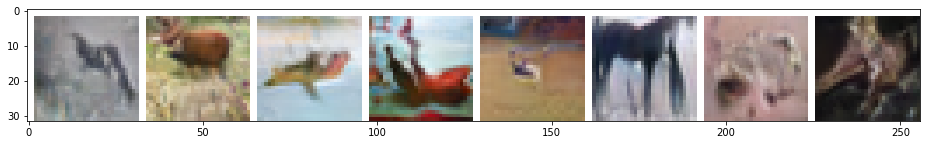

Inception score:   3.310 +-   0.070
step: 49010   time:   3.053  lr: 1.0198000e-04  loss_d:  -1.596  loss_g:   1.743
step: 49020   time:   1.228  lr: 1.0196000e-04  loss_d:  -1.621  loss_g:   2.922
step: 49030   time:   1.227  lr: 1.0194000e-04  loss_d:  -1.550  loss_g:   2.669
step: 49040   time:   1.230  lr: 1.0192000e-04  loss_d:  -1.596  loss_g:   1.976
step: 49050   time:   1.233  lr: 1.0190000e-04  loss_d:  -1.578  loss_g:   3.222
step: 49060   time:   1.230  lr: 1.0188000e-04  loss_d:  -1.575  loss_g:   1.826
step: 49070   time:   1.226  lr: 1.0186000e-04  loss_d:  -1.604  loss_g:   1.938
step: 49080   time:   1.226  lr: 1.0184000e-04  loss_d:  -1.592  loss_g:   2.788
step: 49090   time:   1.230  lr: 1.0182000e-04  loss_d:  -1.582  loss_g:   1.972
step: 49100   time:   1.233  lr: 1.0180000e-04  loss_d:  -1.619  loss_g:   2.546
step: 49110   time:   1.226  lr: 1.0178000e-04  loss_d:  -1.558  loss_g:   2.792
step: 49120   time:   1.232  lr: 1.0176000e-04  loss_d:  -1.580  loss_g: 

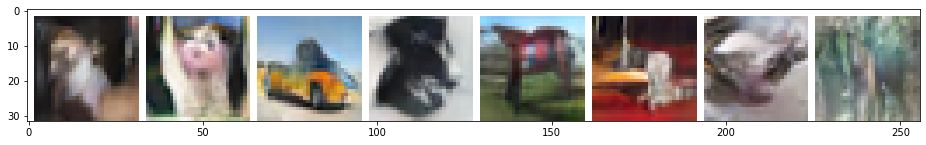

Inception score:   3.412 +-   0.055
step: 50010   time:   3.040  lr: 9.9980000e-05  loss_d:  -1.585  loss_g:   1.743
step: 50020   time:   1.219  lr: 9.9960000e-05  loss_d:  -1.621  loss_g:   2.607
step: 50030   time:   1.252  lr: 9.9940000e-05  loss_d:  -1.613  loss_g:   2.909
step: 50040   time:   1.223  lr: 9.9920000e-05  loss_d:  -1.600  loss_g:   2.916
step: 50050   time:   1.246  lr: 9.9900000e-05  loss_d:  -1.625  loss_g:   2.807
step: 50060   time:   1.242  lr: 9.9880000e-05  loss_d:  -1.610  loss_g:   2.949
step: 50070   time:   1.239  lr: 9.9860000e-05  loss_d:  -1.601  loss_g:   2.215
step: 50080   time:   1.233  lr: 9.9840000e-05  loss_d:  -1.583  loss_g:   2.738
step: 50090   time:   1.224  lr: 9.9820000e-05  loss_d:  -1.586  loss_g:   1.927
step: 50100   time:   1.232  lr: 9.9800000e-05  loss_d:  -1.609  loss_g:   2.737
step: 50110   time:   1.228  lr: 9.9780000e-05  loss_d:  -1.597  loss_g:   2.424
step: 50120   time:   1.229  lr: 9.9760000e-05  loss_d:  -1.594  loss_g: 

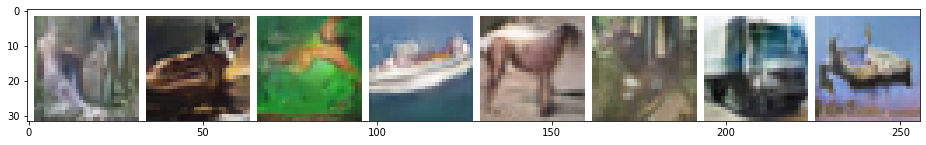

Inception score:   3.435 +-   0.054
step: 51010   time:   3.052  lr: 9.7980000e-05  loss_d:  -1.581  loss_g:   2.656
step: 51020   time:   1.227  lr: 9.7960000e-05  loss_d:  -1.603  loss_g:   2.290
step: 51030   time:   1.226  lr: 9.7940000e-05  loss_d:  -1.651  loss_g:   2.368
step: 51040   time:   1.231  lr: 9.7920000e-05  loss_d:  -1.614  loss_g:   3.358
step: 51050   time:   1.227  lr: 9.7900000e-05  loss_d:  -1.617  loss_g:   2.284
step: 51060   time:   1.230  lr: 9.7880000e-05  loss_d:  -1.639  loss_g:   3.030
step: 51070   time:   1.228  lr: 9.7860000e-05  loss_d:  -1.632  loss_g:   2.766
step: 51080   time:   1.232  lr: 9.7840000e-05  loss_d:  -1.610  loss_g:   2.593
step: 51090   time:   1.225  lr: 9.7820000e-05  loss_d:  -1.599  loss_g:   3.333
step: 51100   time:   1.232  lr: 9.7800000e-05  loss_d:  -1.638  loss_g:   1.796
step: 51110   time:   1.229  lr: 9.7780000e-05  loss_d:  -1.618  loss_g:   1.696
step: 51120   time:   1.226  lr: 9.7760000e-05  loss_d:  -1.653  loss_g: 

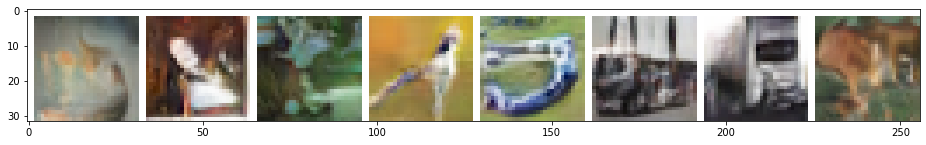

Inception score:   3.445 +-   0.078
step: 52010   time:   3.054  lr: 9.5980000e-05  loss_d:  -1.603  loss_g:   3.025
step: 52020   time:   1.219  lr: 9.5960000e-05  loss_d:  -1.653  loss_g:   2.001
step: 52030   time:   1.230  lr: 9.5940000e-05  loss_d:  -1.620  loss_g:   2.710
step: 52040   time:   1.226  lr: 9.5920000e-05  loss_d:  -1.664  loss_g:   2.228
step: 52050   time:   1.228  lr: 9.5900000e-05  loss_d:  -1.632  loss_g:   3.022
step: 52060   time:   1.232  lr: 9.5880000e-05  loss_d:  -1.648  loss_g:   2.630
step: 52070   time:   1.227  lr: 9.5860000e-05  loss_d:  -1.644  loss_g:   3.139
step: 52080   time:   1.231  lr: 9.5840000e-05  loss_d:  -1.633  loss_g:   2.840
step: 52090   time:   1.226  lr: 9.5820000e-05  loss_d:  -1.663  loss_g:   2.210
step: 52100   time:   1.228  lr: 9.5800000e-05  loss_d:  -1.630  loss_g:   3.193
step: 52110   time:   1.232  lr: 9.5780000e-05  loss_d:  -1.612  loss_g:   2.683
step: 52120   time:   1.236  lr: 9.5760000e-05  loss_d:  -1.651  loss_g: 

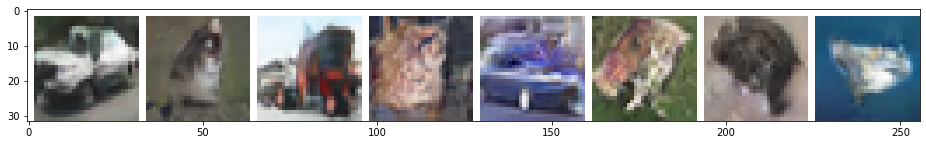

Inception score:   3.424 +-   0.044
step: 53010   time:   3.050  lr: 9.3980000e-05  loss_d:  -1.677  loss_g:   2.839
step: 53020   time:   1.233  lr: 9.3960000e-05  loss_d:  -1.651  loss_g:   2.787
step: 53030   time:   1.233  lr: 9.3940000e-05  loss_d:  -1.659  loss_g:   2.373
step: 53040   time:   1.224  lr: 9.3920000e-05  loss_d:  -1.658  loss_g:   2.227
step: 53050   time:   1.227  lr: 9.3900000e-05  loss_d:  -1.663  loss_g:   2.462
step: 53060   time:   1.234  lr: 9.3880000e-05  loss_d:  -1.667  loss_g:   2.390
step: 53070   time:   1.224  lr: 9.3860000e-05  loss_d:  -1.649  loss_g:   3.330
step: 53080   time:   1.233  lr: 9.3840000e-05  loss_d:  -1.664  loss_g:   2.772
step: 53090   time:   1.226  lr: 9.3820000e-05  loss_d:  -1.646  loss_g:   2.040
step: 53100   time:   1.230  lr: 9.3800000e-05  loss_d:  -1.662  loss_g:   2.714
step: 53110   time:   1.230  lr: 9.3780000e-05  loss_d:  -1.643  loss_g:   2.677
step: 53120   time:   1.224  lr: 9.3760000e-05  loss_d:  -1.653  loss_g: 

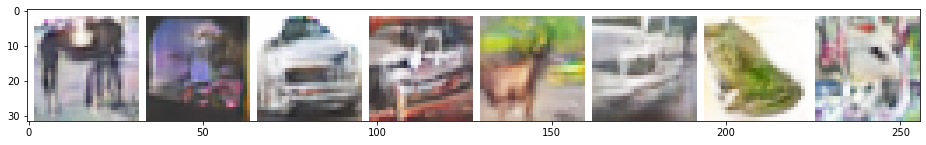

Inception score:   3.425 +-   0.069
step: 54010   time:   3.049  lr: 9.1980000e-05  loss_d:  -1.668  loss_g:   2.475
step: 54020   time:   1.232  lr: 9.1960000e-05  loss_d:  -1.665  loss_g:   3.055
step: 54030   time:   1.228  lr: 9.1940000e-05  loss_d:  -1.666  loss_g:   3.302
step: 54040   time:   1.230  lr: 9.1920000e-05  loss_d:  -1.692  loss_g:   2.691
step: 54050   time:   1.227  lr: 9.1900000e-05  loss_d:  -1.658  loss_g:   2.893
step: 54060   time:   1.234  lr: 9.1880000e-05  loss_d:  -1.673  loss_g:   2.277
step: 54070   time:   1.228  lr: 9.1860000e-05  loss_d:  -1.700  loss_g:   2.277
step: 54080   time:   1.227  lr: 9.1840000e-05  loss_d:  -1.659  loss_g:   2.819
step: 54090   time:   1.231  lr: 9.1820000e-05  loss_d:  -1.659  loss_g:   2.472
step: 54100   time:   1.227  lr: 9.1800000e-05  loss_d:  -1.723  loss_g:   3.208
step: 54110   time:   1.228  lr: 9.1780000e-05  loss_d:  -1.653  loss_g:   3.341
step: 54120   time:   1.227  lr: 9.1760000e-05  loss_d:  -1.678  loss_g: 

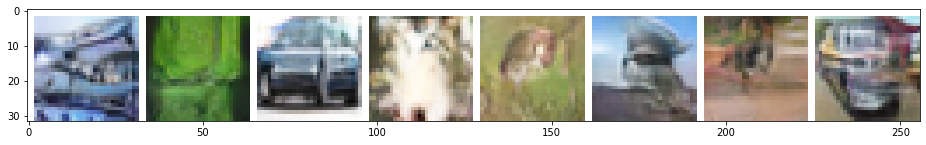

Inception score:   3.532 +-   0.059
step: 55010   time:   3.054  lr: 8.9980000e-05  loss_d:  -1.712  loss_g:   2.703
step: 55020   time:   1.226  lr: 8.9960000e-05  loss_d:  -1.655  loss_g:   2.666
step: 55030   time:   1.227  lr: 8.9940000e-05  loss_d:  -1.728  loss_g:   2.701
step: 55040   time:   1.233  lr: 8.9920000e-05  loss_d:  -1.686  loss_g:   2.960
step: 55050   time:   1.227  lr: 8.9900000e-05  loss_d:  -1.709  loss_g:   3.099
step: 55060   time:   1.229  lr: 8.9880000e-05  loss_d:  -1.676  loss_g:   3.623
step: 55070   time:   1.230  lr: 8.9860000e-05  loss_d:  -1.684  loss_g:   2.918
step: 55080   time:   1.227  lr: 8.9840000e-05  loss_d:  -1.683  loss_g:   2.262
step: 55090   time:   1.228  lr: 8.9820000e-05  loss_d:  -1.689  loss_g:   2.721
step: 55100   time:   1.230  lr: 8.9800000e-05  loss_d:  -1.655  loss_g:   2.589
step: 55110   time:   1.257  lr: 8.9780000e-05  loss_d:  -1.692  loss_g:   2.683
step: 55120   time:   1.240  lr: 8.9760000e-05  loss_d:  -1.689  loss_g: 

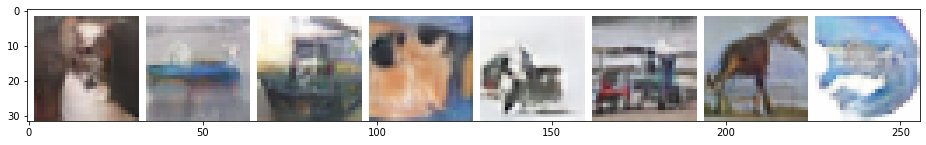

Inception score:   3.397 +-   0.044
step: 56010   time:   3.048  lr: 8.7980000e-05  loss_d:  -1.680  loss_g:   3.134
step: 56020   time:   1.231  lr: 8.7960000e-05  loss_d:  -1.712  loss_g:   2.572
step: 56030   time:   1.233  lr: 8.7940000e-05  loss_d:  -1.701  loss_g:   2.714
step: 56040   time:   1.226  lr: 8.7920000e-05  loss_d:  -1.694  loss_g:   2.514
step: 56050   time:   1.229  lr: 8.7900000e-05  loss_d:  -1.698  loss_g:   2.683
step: 56060   time:   1.230  lr: 8.7880000e-05  loss_d:  -1.742  loss_g:   2.932
step: 56070   time:   1.233  lr: 8.7860000e-05  loss_d:  -1.711  loss_g:   3.062
step: 56080   time:   1.226  lr: 8.7840000e-05  loss_d:  -1.697  loss_g:   3.063
step: 56090   time:   1.228  lr: 8.7820000e-05  loss_d:  -1.724  loss_g:   3.268
step: 56100   time:   1.231  lr: 8.7800000e-05  loss_d:  -1.723  loss_g:   3.032
step: 56110   time:   1.234  lr: 8.7780000e-05  loss_d:  -1.722  loss_g:   3.027
step: 56120   time:   1.222  lr: 8.7760000e-05  loss_d:  -1.714  loss_g: 

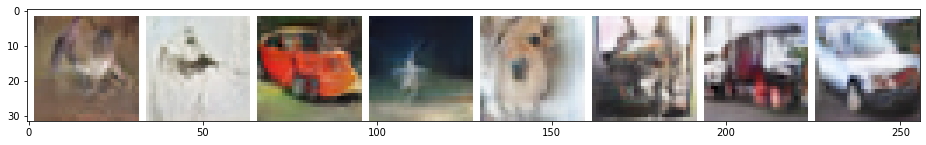

Inception score:   3.436 +-   0.080
step: 57010   time:   3.050  lr: 8.5980000e-05  loss_d:  -1.733  loss_g:   3.224
step: 57020   time:   1.227  lr: 8.5960000e-05  loss_d:  -1.738  loss_g:   3.235
step: 57030   time:   1.231  lr: 8.5940000e-05  loss_d:  -1.721  loss_g:   2.271
step: 57040   time:   1.230  lr: 8.5920000e-05  loss_d:  -1.760  loss_g:   2.764
step: 57050   time:   1.233  lr: 8.5900000e-05  loss_d:  -1.732  loss_g:   2.717
step: 57060   time:   1.222  lr: 8.5880000e-05  loss_d:  -1.697  loss_g:   3.112
step: 57070   time:   1.227  lr: 8.5860000e-05  loss_d:  -1.709  loss_g:   2.748
step: 57080   time:   1.232  lr: 8.5840000e-05  loss_d:  -1.727  loss_g:   3.368
step: 57090   time:   1.226  lr: 8.5820000e-05  loss_d:  -1.750  loss_g:   3.103
step: 57100   time:   1.229  lr: 8.5800000e-05  loss_d:  -1.734  loss_g:   2.594
step: 57110   time:   1.232  lr: 8.5780000e-05  loss_d:  -1.720  loss_g:   3.238
step: 57120   time:   1.227  lr: 8.5760000e-05  loss_d:  -1.738  loss_g: 

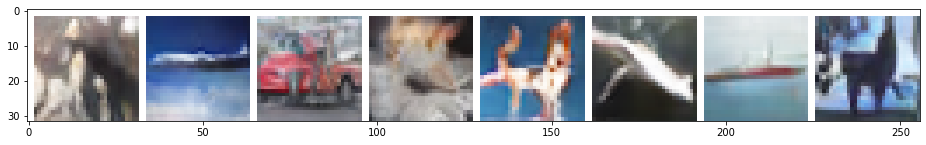

Inception score:   3.388 +-   0.073
step: 58010   time:   3.041  lr: 8.3980000e-05  loss_d:  -1.735  loss_g:   2.954
step: 58020   time:   1.230  lr: 8.3960000e-05  loss_d:  -1.750  loss_g:   3.107
step: 58030   time:   1.226  lr: 8.3940000e-05  loss_d:  -1.749  loss_g:   3.591
step: 58040   time:   1.229  lr: 8.3920000e-05  loss_d:  -1.740  loss_g:   2.649
step: 58050   time:   1.230  lr: 8.3900000e-05  loss_d:  -1.723  loss_g:   2.925
step: 58060   time:   1.276  lr: 8.3880000e-05  loss_d:  -1.738  loss_g:   3.060
step: 58070   time:   1.218  lr: 8.3860000e-05  loss_d:  -1.738  loss_g:   2.505
step: 58080   time:   1.236  lr: 8.3840000e-05  loss_d:  -1.740  loss_g:   3.440
step: 58090   time:   1.230  lr: 8.3820000e-05  loss_d:  -1.750  loss_g:   2.900
step: 58100   time:   1.225  lr: 8.3800000e-05  loss_d:  -1.759  loss_g:   2.643
step: 58110   time:   1.230  lr: 8.3780000e-05  loss_d:  -1.707  loss_g:   3.607
step: 58120   time:   1.228  lr: 8.3760000e-05  loss_d:  -1.747  loss_g: 

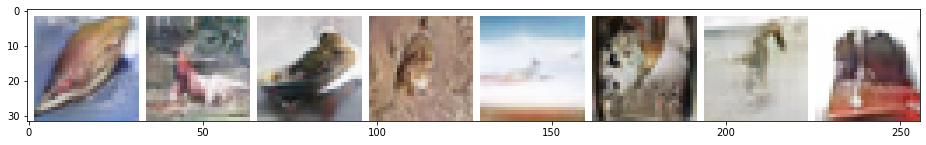

Inception score:   3.389 +-   0.052
step: 59010   time:   3.056  lr: 8.1980000e-05  loss_d:  -1.740  loss_g:   3.050
step: 59020   time:   1.226  lr: 8.1960000e-05  loss_d:  -1.774  loss_g:   3.166
step: 59030   time:   1.233  lr: 8.1940000e-05  loss_d:  -1.769  loss_g:   3.880
step: 59040   time:   1.222  lr: 8.1920000e-05  loss_d:  -1.755  loss_g:   2.872
step: 59050   time:   1.231  lr: 8.1900000e-05  loss_d:  -1.756  loss_g:   4.013
step: 59060   time:   1.228  lr: 8.1880000e-05  loss_d:  -1.743  loss_g:   2.280
step: 59070   time:   1.237  lr: 8.1860000e-05  loss_d:  -1.759  loss_g:   2.770
step: 59080   time:   1.221  lr: 8.1840000e-05  loss_d:  -1.765  loss_g:   3.185
step: 59090   time:   1.231  lr: 8.1820000e-05  loss_d:  -1.748  loss_g:   3.211
step: 59100   time:   1.228  lr: 8.1800000e-05  loss_d:  -1.791  loss_g:   2.803
step: 59110   time:   1.228  lr: 8.1780000e-05  loss_d:  -1.741  loss_g:   2.861
step: 59120   time:   1.227  lr: 8.1760000e-05  loss_d:  -1.792  loss_g: 

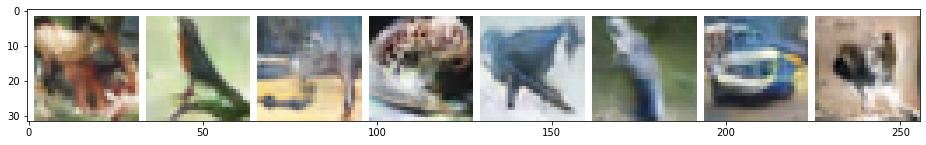

Inception score:   3.454 +-   0.038
step: 60010   time:   3.043  lr: 7.9980000e-05  loss_d:  -1.741  loss_g:   3.136
step: 60020   time:   1.214  lr: 7.9960000e-05  loss_d:  -1.779  loss_g:   3.167
step: 60030   time:   1.237  lr: 7.9940000e-05  loss_d:  -1.785  loss_g:   2.636
step: 60040   time:   1.243  lr: 7.9920000e-05  loss_d:  -1.771  loss_g:   3.195
step: 60050   time:   1.231  lr: 7.9900000e-05  loss_d:  -1.782  loss_g:   3.536
step: 60060   time:   1.226  lr: 7.9880000e-05  loss_d:  -1.779  loss_g:   3.167
step: 60070   time:   1.230  lr: 7.9860000e-05  loss_d:  -1.763  loss_g:   3.537
step: 60080   time:   1.230  lr: 7.9840000e-05  loss_d:  -1.777  loss_g:   2.684
step: 60090   time:   1.235  lr: 7.9820000e-05  loss_d:  -1.800  loss_g:   3.294
step: 60100   time:   1.243  lr: 7.9800000e-05  loss_d:  -1.740  loss_g:   3.466
step: 60110   time:   1.227  lr: 7.9780000e-05  loss_d:  -1.767  loss_g:   3.542
step: 60120   time:   1.228  lr: 7.9760000e-05  loss_d:  -1.784  loss_g: 

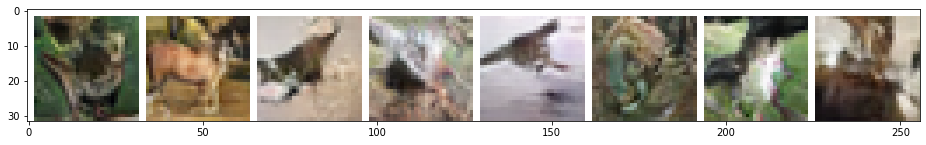

Inception score:   3.342 +-   0.058
step: 61010   time:   3.055  lr: 7.7980000e-05  loss_d:  -1.787  loss_g:   3.049
step: 61020   time:   1.223  lr: 7.7960000e-05  loss_d:  -1.783  loss_g:   2.979
step: 61030   time:   1.230  lr: 7.7940000e-05  loss_d:  -1.788  loss_g:   2.767
step: 61040   time:   1.231  lr: 7.7920000e-05  loss_d:  -1.785  loss_g:   3.062
step: 61050   time:   1.230  lr: 7.7900000e-05  loss_d:  -1.795  loss_g:   3.287
step: 61060   time:   1.228  lr: 7.7880000e-05  loss_d:  -1.810  loss_g:   3.439
step: 61070   time:   1.232  lr: 7.7860000e-05  loss_d:  -1.773  loss_g:   3.246
step: 61080   time:   1.249  lr: 7.7840000e-05  loss_d:  -1.779  loss_g:   4.223
step: 61090   time:   1.229  lr: 7.7820000e-05  loss_d:  -1.798  loss_g:   3.143
step: 61100   time:   1.223  lr: 7.7800000e-05  loss_d:  -1.782  loss_g:   3.606
step: 61110   time:   1.253  lr: 7.7780000e-05  loss_d:  -1.802  loss_g:   2.745
step: 61120   time:   1.228  lr: 7.7760000e-05  loss_d:  -1.796  loss_g: 

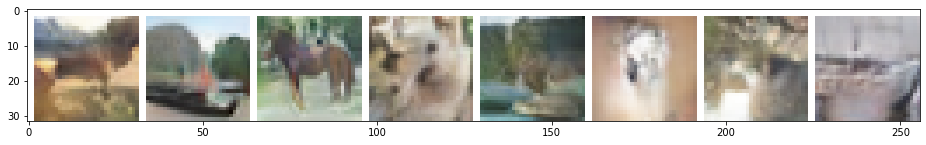

Inception score:   3.396 +-   0.050
step: 62010   time:   3.054  lr: 7.5980000e-05  loss_d:  -1.798  loss_g:   3.158
step: 62020   time:   1.230  lr: 7.5960000e-05  loss_d:  -1.808  loss_g:   3.347
step: 62030   time:   1.227  lr: 7.5940000e-05  loss_d:  -1.818  loss_g:   3.689
step: 62040   time:   1.232  lr: 7.5920000e-05  loss_d:  -1.812  loss_g:   3.728
step: 62050   time:   1.229  lr: 7.5900000e-05  loss_d:  -1.805  loss_g:   3.483
step: 62060   time:   1.234  lr: 7.5880000e-05  loss_d:  -1.796  loss_g:   3.291
step: 62070   time:   1.241  lr: 7.5860000e-05  loss_d:  -1.817  loss_g:   3.648
step: 62080   time:   1.228  lr: 7.5840000e-05  loss_d:  -1.807  loss_g:   3.707
step: 62090   time:   1.229  lr: 7.5820000e-05  loss_d:  -1.777  loss_g:   3.670
step: 62100   time:   1.234  lr: 7.5800000e-05  loss_d:  -1.803  loss_g:   3.326
step: 62110   time:   1.223  lr: 7.5780000e-05  loss_d:  -1.789  loss_g:   3.534
step: 62120   time:   1.230  lr: 7.5760000e-05  loss_d:  -1.811  loss_g: 

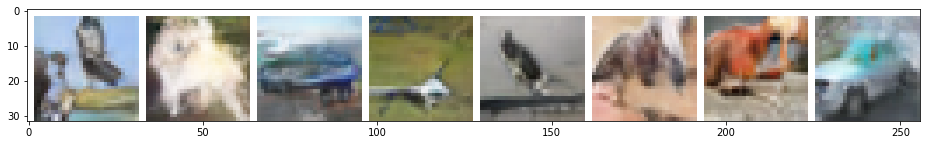

Inception score:   3.451 +-   0.083
step: 63010   time:   3.050  lr: 7.3980000e-05  loss_d:  -1.804  loss_g:   3.479
step: 63020   time:   1.228  lr: 7.3960000e-05  loss_d:  -1.857  loss_g:   3.769
step: 63030   time:   1.232  lr: 7.3940000e-05  loss_d:  -1.809  loss_g:   4.233
step: 63040   time:   1.232  lr: 7.3920000e-05  loss_d:  -1.815  loss_g:   3.556
step: 63050   time:   1.225  lr: 7.3900000e-05  loss_d:  -1.808  loss_g:   3.512
step: 63060   time:   1.254  lr: 7.3880000e-05  loss_d:  -1.829  loss_g:   3.234
step: 63070   time:   1.223  lr: 7.3860000e-05  loss_d:  -1.828  loss_g:   3.398
step: 63080   time:   1.232  lr: 7.3840000e-05  loss_d:  -1.834  loss_g:   3.470
step: 63090   time:   1.226  lr: 7.3820000e-05  loss_d:  -1.839  loss_g:   3.995
step: 63100   time:   1.228  lr: 7.3800000e-05  loss_d:  -1.819  loss_g:   3.566
step: 63110   time:   1.228  lr: 7.3780000e-05  loss_d:  -1.823  loss_g:   3.911
step: 63120   time:   1.230  lr: 7.3760000e-05  loss_d:  -1.811  loss_g: 

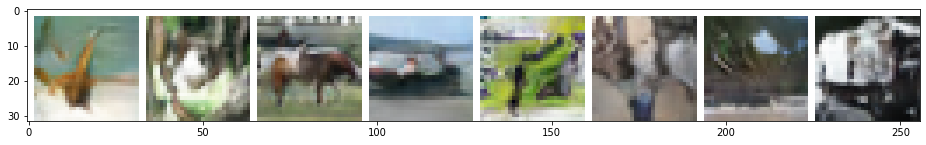

Inception score:   3.430 +-   0.063
step: 64010   time:   3.037  lr: 7.1980000e-05  loss_d:  -1.842  loss_g:   3.091
step: 64020   time:   1.221  lr: 7.1960000e-05  loss_d:  -1.871  loss_g:   4.029
step: 64030   time:   1.230  lr: 7.1940000e-05  loss_d:  -1.840  loss_g:   3.665
step: 64040   time:   1.227  lr: 7.1920000e-05  loss_d:  -1.858  loss_g:   3.483
step: 64050   time:   1.229  lr: 7.1900000e-05  loss_d:  -1.806  loss_g:   3.565
step: 64060   time:   1.268  lr: 7.1880000e-05  loss_d:  -1.816  loss_g:   3.871
step: 64070   time:   1.234  lr: 7.1860000e-05  loss_d:  -1.843  loss_g:   3.539
step: 64080   time:   1.231  lr: 7.1840000e-05  loss_d:  -1.861  loss_g:   3.362
step: 64090   time:   1.226  lr: 7.1820000e-05  loss_d:  -1.848  loss_g:   3.944
step: 64100   time:   1.229  lr: 7.1800000e-05  loss_d:  -1.842  loss_g:   3.833
step: 64110   time:   1.232  lr: 7.1780000e-05  loss_d:  -1.852  loss_g:   3.782
step: 64120   time:   1.226  lr: 7.1760000e-05  loss_d:  -1.828  loss_g: 

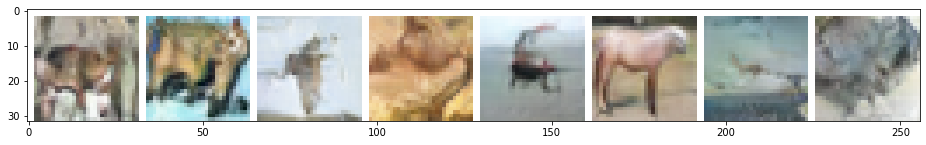

Inception score:   3.399 +-   0.042
step: 65010   time:   3.043  lr: 6.9980000e-05  loss_d:  -1.847  loss_g:   2.881
step: 65020   time:   1.217  lr: 6.9960000e-05  loss_d:  -1.867  loss_g:   3.727
step: 65030   time:   1.238  lr: 6.9940000e-05  loss_d:  -1.844  loss_g:   3.515
step: 65040   time:   1.220  lr: 6.9920000e-05  loss_d:  -1.823  loss_g:   4.649
step: 65050   time:   1.228  lr: 6.9900000e-05  loss_d:  -1.841  loss_g:   3.581
step: 65060   time:   1.230  lr: 6.9880000e-05  loss_d:  -1.869  loss_g:   3.389
step: 65070   time:   1.256  lr: 6.9860000e-05  loss_d:  -1.835  loss_g:   3.837
step: 65080   time:   1.221  lr: 6.9840000e-05  loss_d:  -1.851  loss_g:   3.439
step: 65090   time:   1.229  lr: 6.9820000e-05  loss_d:  -1.857  loss_g:   3.599
step: 65100   time:   1.231  lr: 6.9800000e-05  loss_d:  -1.822  loss_g:   3.461
step: 65110   time:   1.226  lr: 6.9780000e-05  loss_d:  -1.856  loss_g:   3.641
step: 65120   time:   1.228  lr: 6.9760000e-05  loss_d:  -1.866  loss_g: 

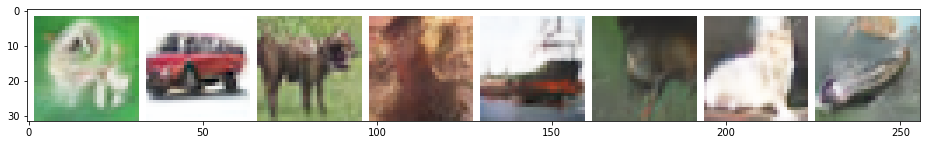

Inception score:   3.457 +-   0.037
step: 66010   time:   3.059  lr: 6.7980000e-05  loss_d:  -1.875  loss_g:   3.304
step: 66020   time:   1.219  lr: 6.7960000e-05  loss_d:  -1.840  loss_g:   3.594
step: 66030   time:   1.237  lr: 6.7940000e-05  loss_d:  -1.857  loss_g:   3.738
step: 66040   time:   1.243  lr: 6.7920000e-05  loss_d:  -1.876  loss_g:   3.286
step: 66050   time:   1.226  lr: 6.7900000e-05  loss_d:  -1.858  loss_g:   3.703
step: 66060   time:   1.233  lr: 6.7880000e-05  loss_d:  -1.844  loss_g:   3.826
step: 66070   time:   1.231  lr: 6.7860000e-05  loss_d:  -1.834  loss_g:   4.131
step: 66080   time:   1.238  lr: 6.7840000e-05  loss_d:  -1.859  loss_g:   3.368
step: 66090   time:   1.235  lr: 6.7820000e-05  loss_d:  -1.848  loss_g:   4.205
step: 66100   time:   1.229  lr: 6.7800000e-05  loss_d:  -1.883  loss_g:   3.122
step: 66110   time:   1.229  lr: 6.7780000e-05  loss_d:  -1.858  loss_g:   3.757
step: 66120   time:   1.229  lr: 6.7760000e-05  loss_d:  -1.888  loss_g: 

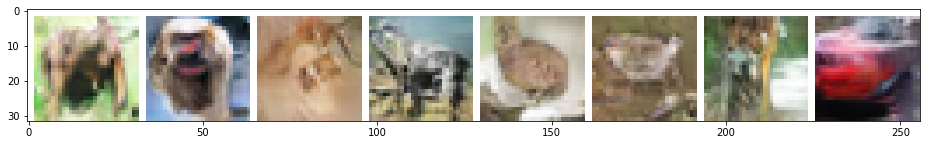

Inception score:   3.443 +-   0.076
step: 67010   time:   3.047  lr: 6.5980000e-05  loss_d:  -1.869  loss_g:   3.533
step: 67020   time:   1.231  lr: 6.5960000e-05  loss_d:  -1.891  loss_g:   4.240
step: 67030   time:   1.230  lr: 6.5940000e-05  loss_d:  -1.868  loss_g:   3.126
step: 67040   time:   1.230  lr: 6.5920000e-05  loss_d:  -1.877  loss_g:   3.726
step: 67050   time:   1.244  lr: 6.5900000e-05  loss_d:  -1.892  loss_g:   2.851
step: 67060   time:   1.251  lr: 6.5880000e-05  loss_d:  -1.899  loss_g:   3.762
step: 67070   time:   1.230  lr: 6.5860000e-05  loss_d:  -1.868  loss_g:   3.604
step: 67080   time:   1.232  lr: 6.5840000e-05  loss_d:  -1.895  loss_g:   4.181
step: 67090   time:   1.228  lr: 6.5820000e-05  loss_d:  -1.872  loss_g:   3.831
step: 67100   time:   1.227  lr: 6.5800000e-05  loss_d:  -1.903  loss_g:   3.910
step: 67110   time:   1.230  lr: 6.5780000e-05  loss_d:  -1.894  loss_g:   3.339
step: 67120   time:   1.227  lr: 6.5760000e-05  loss_d:  -1.895  loss_g: 

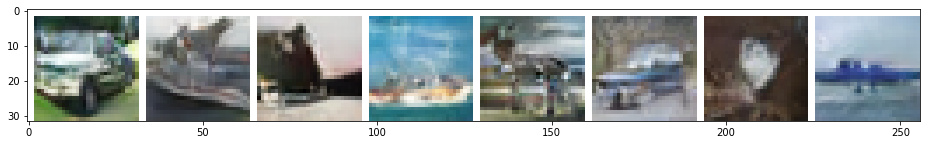

Inception score:   3.410 +-   0.053
step: 68010   time:   3.040  lr: 6.3980000e-05  loss_d:  -1.897  loss_g:   3.770
step: 68020   time:   1.220  lr: 6.3960000e-05  loss_d:  -1.922  loss_g:   3.730
step: 68030   time:   1.236  lr: 6.3940000e-05  loss_d:  -1.900  loss_g:   4.221
step: 68040   time:   1.223  lr: 6.3920000e-05  loss_d:  -1.891  loss_g:   3.839
step: 68050   time:   1.229  lr: 6.3900000e-05  loss_d:  -1.871  loss_g:   4.145
step: 68060   time:   1.228  lr: 6.3880000e-05  loss_d:  -1.904  loss_g:   3.336
step: 68070   time:   1.230  lr: 6.3860000e-05  loss_d:  -1.890  loss_g:   3.728
step: 68080   time:   1.227  lr: 6.3840000e-05  loss_d:  -1.923  loss_g:   3.677
step: 68090   time:   1.227  lr: 6.3820000e-05  loss_d:  -1.878  loss_g:   4.211
step: 68100   time:   1.232  lr: 6.3800000e-05  loss_d:  -1.897  loss_g:   3.957
step: 68110   time:   1.228  lr: 6.3780000e-05  loss_d:  -1.888  loss_g:   3.994
step: 68120   time:   1.230  lr: 6.3760000e-05  loss_d:  -1.896  loss_g: 

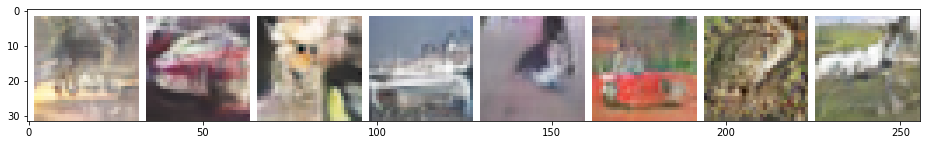

Inception score:   3.419 +-   0.056
step: 69010   time:   3.055  lr: 6.1980000e-05  loss_d:  -1.901  loss_g:   3.461
step: 69020   time:   1.225  lr: 6.1960000e-05  loss_d:  -1.899  loss_g:   3.990
step: 69030   time:   1.231  lr: 6.1940000e-05  loss_d:  -1.921  loss_g:   4.059
step: 69040   time:   1.237  lr: 6.1920000e-05  loss_d:  -1.918  loss_g:   4.212
step: 69050   time:   1.224  lr: 6.1900000e-05  loss_d:  -1.897  loss_g:   4.194
step: 69060   time:   1.225  lr: 6.1880000e-05  loss_d:  -1.904  loss_g:   3.852
step: 69070   time:   1.234  lr: 6.1860000e-05  loss_d:  -1.915  loss_g:   3.832
step: 69080   time:   1.224  lr: 6.1840000e-05  loss_d:  -1.910  loss_g:   3.938
step: 69090   time:   1.228  lr: 6.1820000e-05  loss_d:  -1.911  loss_g:   3.724
step: 69100   time:   1.234  lr: 6.1800000e-05  loss_d:  -1.914  loss_g:   3.984
step: 69110   time:   1.242  lr: 6.1780000e-05  loss_d:  -1.924  loss_g:   4.151
step: 69120   time:   1.253  lr: 6.1760000e-05  loss_d:  -1.934  loss_g: 

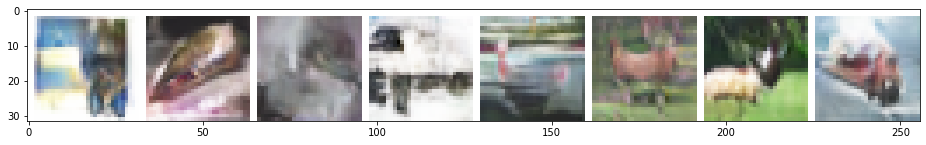

Inception score:   3.430 +-   0.087
step: 70010   time:   3.052  lr: 5.9980000e-05  loss_d:  -1.980  loss_g:   4.004
step: 70020   time:   1.232  lr: 5.9960000e-05  loss_d:  -1.922  loss_g:   3.826
step: 70030   time:   1.235  lr: 5.9940000e-05  loss_d:  -1.920  loss_g:   3.817
step: 70040   time:   1.226  lr: 5.9920000e-05  loss_d:  -1.914  loss_g:   4.296
step: 70050   time:   1.224  lr: 5.9900000e-05  loss_d:  -1.924  loss_g:   4.104
step: 70060   time:   1.227  lr: 5.9880000e-05  loss_d:  -1.901  loss_g:   4.879
step: 70070   time:   1.232  lr: 5.9860000e-05  loss_d:  -1.941  loss_g:   3.962
step: 70080   time:   1.228  lr: 5.9840000e-05  loss_d:  -1.903  loss_g:   3.715
step: 70090   time:   1.254  lr: 5.9820000e-05  loss_d:  -1.940  loss_g:   3.778
step: 70100   time:   1.224  lr: 5.9800000e-05  loss_d:  -1.927  loss_g:   3.417
step: 70110   time:   1.227  lr: 5.9780000e-05  loss_d:  -1.930  loss_g:   4.098
step: 70120   time:   1.232  lr: 5.9760000e-05  loss_d:  -1.925  loss_g: 

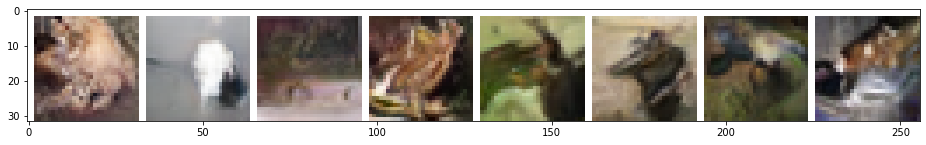

Inception score:   3.318 +-   0.046
step: 71010   time:   3.056  lr: 5.7980000e-05  loss_d:  -1.922  loss_g:   3.891
step: 71020   time:   1.224  lr: 5.7960000e-05  loss_d:  -1.956  loss_g:   3.568
step: 71030   time:   1.228  lr: 5.7940000e-05  loss_d:  -1.942  loss_g:   4.007
step: 71040   time:   1.227  lr: 5.7920000e-05  loss_d:  -1.944  loss_g:   3.983
step: 71050   time:   1.233  lr: 5.7900000e-05  loss_d:  -1.944  loss_g:   3.668
step: 71060   time:   1.226  lr: 5.7880000e-05  loss_d:  -1.941  loss_g:   4.065
step: 71070   time:   1.231  lr: 5.7860000e-05  loss_d:  -1.944  loss_g:   3.901
step: 71080   time:   1.229  lr: 5.7840000e-05  loss_d:  -1.913  loss_g:   3.467
step: 71090   time:   1.239  lr: 5.7820000e-05  loss_d:  -1.954  loss_g:   4.198
step: 71100   time:   1.263  lr: 5.7800000e-05  loss_d:  -1.931  loss_g:   4.214
step: 71110   time:   1.223  lr: 5.7780000e-05  loss_d:  -1.934  loss_g:   3.320
step: 71120   time:   1.232  lr: 5.7760000e-05  loss_d:  -1.960  loss_g: 

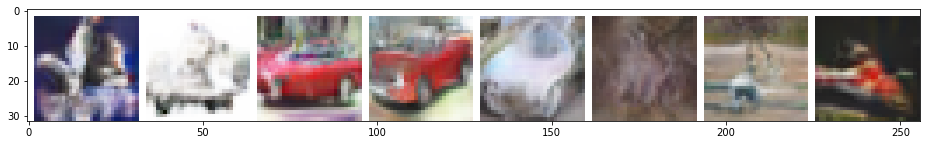

Inception score:   3.431 +-   0.051
step: 72010   time:   3.066  lr: 5.5980000e-05  loss_d:  -1.954  loss_g:   4.043
step: 72020   time:   1.231  lr: 5.5960000e-05  loss_d:  -1.961  loss_g:   4.316
step: 72030   time:   1.231  lr: 5.5940000e-05  loss_d:  -1.951  loss_g:   3.816
step: 72040   time:   1.228  lr: 5.5920000e-05  loss_d:  -1.954  loss_g:   3.780
step: 72050   time:   1.228  lr: 5.5900000e-05  loss_d:  -1.964  loss_g:   3.918
step: 72060   time:   1.252  lr: 5.5880000e-05  loss_d:  -1.954  loss_g:   4.750
step: 72070   time:   1.253  lr: 5.5860000e-05  loss_d:  -1.956  loss_g:   3.961
step: 72080   time:   1.224  lr: 5.5840000e-05  loss_d:  -1.949  loss_g:   3.915
step: 72090   time:   1.254  lr: 5.5820000e-05  loss_d:  -1.938  loss_g:   4.491
step: 72100   time:   1.225  lr: 5.5800000e-05  loss_d:  -1.987  loss_g:   4.046
step: 72110   time:   1.229  lr: 5.5780000e-05  loss_d:  -1.962  loss_g:   4.683
step: 72120   time:   1.265  lr: 5.5760000e-05  loss_d:  -1.973  loss_g: 

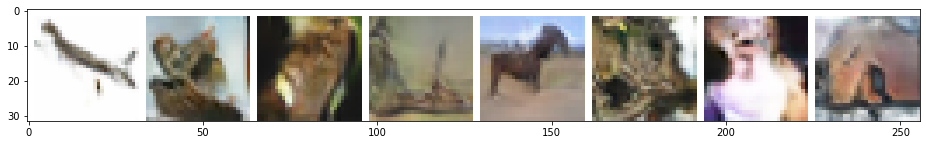

Inception score:   3.335 +-   0.062
step: 73010   time:   3.049  lr: 5.3980000e-05  loss_d:  -1.981  loss_g:   4.379
step: 73020   time:   1.230  lr: 5.3960000e-05  loss_d:  -1.942  loss_g:   4.390
step: 73030   time:   1.230  lr: 5.3940000e-05  loss_d:  -1.976  loss_g:   4.535
step: 73040   time:   1.226  lr: 5.3920000e-05  loss_d:  -1.949  loss_g:   3.885
step: 73050   time:   1.228  lr: 5.3900000e-05  loss_d:  -1.963  loss_g:   4.141
step: 73060   time:   1.232  lr: 5.3880000e-05  loss_d:  -1.949  loss_g:   3.937
step: 73070   time:   1.229  lr: 5.3860000e-05  loss_d:  -1.978  loss_g:   3.415
step: 73080   time:   1.228  lr: 5.3840000e-05  loss_d:  -1.972  loss_g:   4.051
step: 73090   time:   1.228  lr: 5.3820000e-05  loss_d:  -1.965  loss_g:   4.116
step: 73100   time:   1.232  lr: 5.3800000e-05  loss_d:  -1.978  loss_g:   4.127
step: 73110   time:   1.240  lr: 5.3780000e-05  loss_d:  -1.954  loss_g:   4.529
step: 73120   time:   1.234  lr: 5.3760000e-05  loss_d:  -1.990  loss_g: 

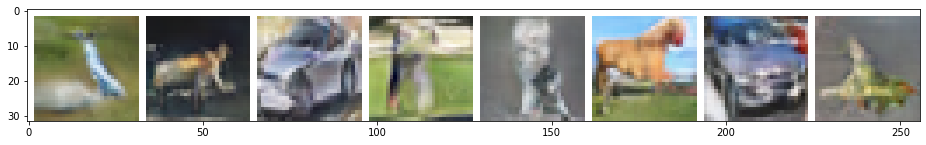

Inception score:   3.384 +-   0.054
step: 74010   time:   3.067  lr: 5.1980000e-05  loss_d:  -1.981  loss_g:   4.311
step: 74020   time:   1.235  lr: 5.1960000e-05  loss_d:  -1.990  loss_g:   4.200
step: 74030   time:   1.229  lr: 5.1940000e-05  loss_d:  -1.986  loss_g:   4.703
step: 74040   time:   1.230  lr: 5.1920000e-05  loss_d:  -1.967  loss_g:   4.316
step: 74050   time:   1.226  lr: 5.1900000e-05  loss_d:  -1.963  loss_g:   3.975
step: 74060   time:   1.234  lr: 5.1880000e-05  loss_d:  -1.958  loss_g:   3.906
step: 74070   time:   1.226  lr: 5.1860000e-05  loss_d:  -1.981  loss_g:   4.074
step: 74080   time:   1.228  lr: 5.1840000e-05  loss_d:  -1.998  loss_g:   3.061
step: 74090   time:   1.229  lr: 5.1820000e-05  loss_d:  -1.983  loss_g:   4.338
step: 74100   time:   1.231  lr: 5.1800000e-05  loss_d:  -1.962  loss_g:   3.668
step: 74110   time:   1.227  lr: 5.1780000e-05  loss_d:  -1.961  loss_g:   4.196
step: 74120   time:   1.259  lr: 5.1760000e-05  loss_d:  -1.941  loss_g: 

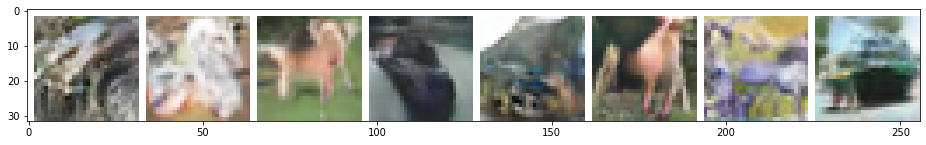

Inception score:   3.457 +-   0.069
step: 75010   time:   3.064  lr: 4.9980000e-05  loss_d:  -1.989  loss_g:   4.299
step: 75020   time:   1.232  lr: 4.9960000e-05  loss_d:  -1.974  loss_g:   3.990
step: 75030   time:   1.233  lr: 4.9940000e-05  loss_d:  -2.020  loss_g:   3.625
step: 75040   time:   1.227  lr: 4.9920000e-05  loss_d:  -2.013  loss_g:   4.185
step: 75050   time:   1.230  lr: 4.9900000e-05  loss_d:  -1.977  loss_g:   4.408
step: 75060   time:   1.229  lr: 4.9880000e-05  loss_d:  -1.973  loss_g:   4.119
step: 75070   time:   1.229  lr: 4.9860000e-05  loss_d:  -1.995  loss_g:   4.476
step: 75080   time:   1.228  lr: 4.9840000e-05  loss_d:  -1.981  loss_g:   4.982
step: 75090   time:   1.232  lr: 4.9820000e-05  loss_d:  -2.005  loss_g:   2.857
step: 75100   time:   1.228  lr: 4.9800000e-05  loss_d:  -2.009  loss_g:   4.413
step: 75110   time:   1.225  lr: 4.9780000e-05  loss_d:  -2.011  loss_g:   3.787
step: 75120   time:   1.244  lr: 4.9760000e-05  loss_d:  -1.975  loss_g: 

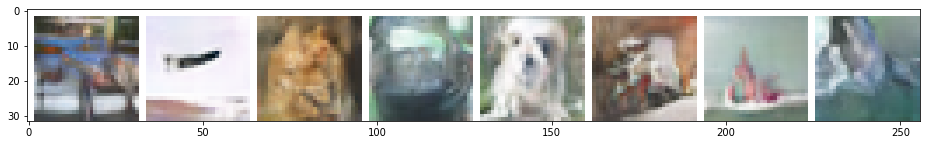

Inception score:   3.439 +-   0.055
step: 76010   time:   3.065  lr: 4.7980000e-05  loss_d:  -2.016  loss_g:   4.541
step: 76020   time:   1.216  lr: 4.7960000e-05  loss_d:  -1.993  loss_g:   3.942
step: 76030   time:   1.232  lr: 4.7940000e-05  loss_d:  -1.994  loss_g:   4.247
step: 76040   time:   1.227  lr: 4.7920000e-05  loss_d:  -2.009  loss_g:   3.626
step: 76050   time:   1.231  lr: 4.7900000e-05  loss_d:  -2.022  loss_g:   4.051
step: 76060   time:   1.225  lr: 4.7880000e-05  loss_d:  -2.026  loss_g:   4.645
step: 76070   time:   1.238  lr: 4.7860000e-05  loss_d:  -1.989  loss_g:   4.909
step: 76080   time:   1.221  lr: 4.7840000e-05  loss_d:  -1.997  loss_g:   5.019
step: 76090   time:   1.230  lr: 4.7820000e-05  loss_d:  -1.998  loss_g:   3.670
step: 76100   time:   1.251  lr: 4.7800000e-05  loss_d:  -1.993  loss_g:   4.453
step: 76110   time:   1.245  lr: 4.7780000e-05  loss_d:  -2.012  loss_g:   3.973
step: 76120   time:   1.229  lr: 4.7760000e-05  loss_d:  -1.996  loss_g: 

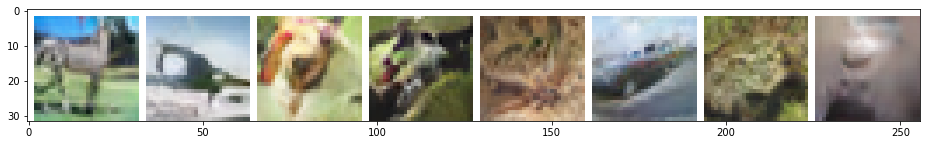

Inception score:   3.415 +-   0.060
step: 77010   time:   3.079  lr: 4.5980000e-05  loss_d:  -1.976  loss_g:   4.673
step: 77020   time:   1.221  lr: 4.5960000e-05  loss_d:  -1.998  loss_g:   4.774
step: 77030   time:   1.234  lr: 4.5940000e-05  loss_d:  -2.015  loss_g:   4.297
step: 77040   time:   1.223  lr: 4.5920000e-05  loss_d:  -1.996  loss_g:   4.544
step: 77050   time:   1.230  lr: 4.5900000e-05  loss_d:  -2.005  loss_g:   3.915
step: 77060   time:   1.228  lr: 4.5880000e-05  loss_d:  -2.014  loss_g:   4.258
step: 77070   time:   1.229  lr: 4.5860000e-05  loss_d:  -2.038  loss_g:   4.328
step: 77080   time:   1.230  lr: 4.5840000e-05  loss_d:  -2.044  loss_g:   4.748
step: 77090   time:   1.253  lr: 4.5820000e-05  loss_d:  -2.006  loss_g:   4.248
step: 77100   time:   1.228  lr: 4.5800000e-05  loss_d:  -2.006  loss_g:   4.590
step: 77110   time:   1.224  lr: 4.5780000e-05  loss_d:  -1.998  loss_g:   4.357
step: 77120   time:   1.227  lr: 4.5760000e-05  loss_d:  -2.016  loss_g: 

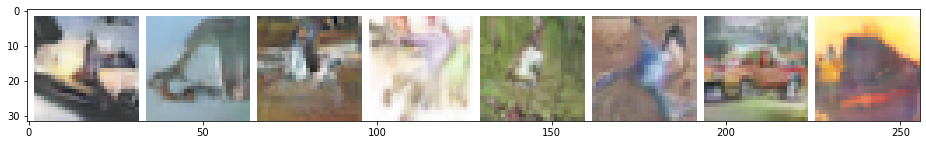

Inception score:   3.359 +-   0.066
step: 78010   time:   3.055  lr: 4.3980000e-05  loss_d:  -2.034  loss_g:   4.110
step: 78020   time:   1.221  lr: 4.3960000e-05  loss_d:  -2.019  loss_g:   4.707
step: 78030   time:   1.227  lr: 4.3940000e-05  loss_d:  -2.041  loss_g:   4.434
step: 78040   time:   1.231  lr: 4.3920000e-05  loss_d:  -2.025  loss_g:   4.625
step: 78050   time:   1.237  lr: 4.3900000e-05  loss_d:  -2.041  loss_g:   4.707
step: 78060   time:   1.228  lr: 4.3880000e-05  loss_d:  -2.053  loss_g:   4.614
step: 78070   time:   1.223  lr: 4.3860000e-05  loss_d:  -1.998  loss_g:   4.109
step: 78080   time:   1.230  lr: 4.3840000e-05  loss_d:  -2.051  loss_g:   3.642
step: 78090   time:   1.226  lr: 4.3820000e-05  loss_d:  -2.010  loss_g:   4.590
step: 78100   time:   1.228  lr: 4.3800000e-05  loss_d:  -2.005  loss_g:   4.936
step: 78110   time:   1.227  lr: 4.3780000e-05  loss_d:  -2.007  loss_g:   4.275
step: 78120   time:   1.232  lr: 4.3760000e-05  loss_d:  -2.019  loss_g: 

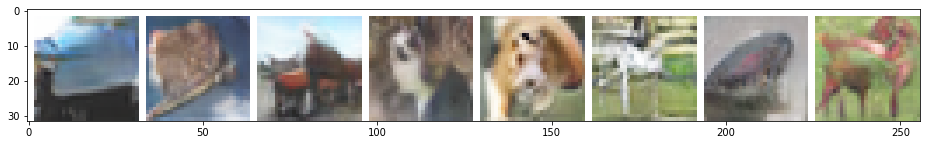

Inception score:   3.475 +-   0.049
step: 79010   time:   3.052  lr: 4.1980000e-05  loss_d:  -2.049  loss_g:   4.218
step: 79020   time:   1.220  lr: 4.1960000e-05  loss_d:  -2.040  loss_g:   4.146
step: 79030   time:   1.233  lr: 4.1940000e-05  loss_d:  -2.036  loss_g:   4.615
step: 79040   time:   1.227  lr: 4.1920000e-05  loss_d:  -2.019  loss_g:   4.735
step: 79050   time:   1.228  lr: 4.1900000e-05  loss_d:  -2.030  loss_g:   4.681
step: 79060   time:   1.230  lr: 4.1880000e-05  loss_d:  -2.060  loss_g:   4.798
step: 79070   time:   1.227  lr: 4.1860000e-05  loss_d:  -2.020  loss_g:   4.515
step: 79080   time:   1.231  lr: 4.1840000e-05  loss_d:  -2.041  loss_g:   4.205
step: 79090   time:   1.230  lr: 4.1820000e-05  loss_d:  -2.030  loss_g:   4.679
step: 79100   time:   1.229  lr: 4.1800000e-05  loss_d:  -2.047  loss_g:   4.431
step: 79110   time:   1.225  lr: 4.1780000e-05  loss_d:  -2.030  loss_g:   4.635
step: 79120   time:   1.231  lr: 4.1760000e-05  loss_d:  -2.051  loss_g: 

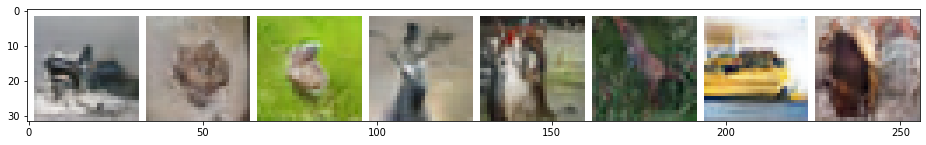

Inception score:   3.457 +-   0.051
step: 80010   time:   3.061  lr: 3.9980000e-05  loss_d:  -2.037  loss_g:   3.940
step: 80020   time:   1.214  lr: 3.9960000e-05  loss_d:  -2.043  loss_g:   4.443
step: 80030   time:   1.251  lr: 3.9940000e-05  loss_d:  -2.075  loss_g:   4.065
step: 80040   time:   1.233  lr: 3.9920000e-05  loss_d:  -2.036  loss_g:   5.101
step: 80050   time:   1.223  lr: 3.9900000e-05  loss_d:  -2.051  loss_g:   4.536
step: 80060   time:   1.230  lr: 3.9880000e-05  loss_d:  -2.037  loss_g:   4.589
step: 80070   time:   1.226  lr: 3.9860000e-05  loss_d:  -2.050  loss_g:   4.263
step: 80080   time:   1.230  lr: 3.9840000e-05  loss_d:  -2.045  loss_g:   5.078
step: 80090   time:   1.232  lr: 3.9820000e-05  loss_d:  -2.035  loss_g:   3.866
step: 80100   time:   1.227  lr: 3.9800000e-05  loss_d:  -2.066  loss_g:   4.102
step: 80110   time:   1.227  lr: 3.9780000e-05  loss_d:  -2.049  loss_g:   4.218
step: 80120   time:   1.231  lr: 3.9760000e-05  loss_d:  -2.058  loss_g: 

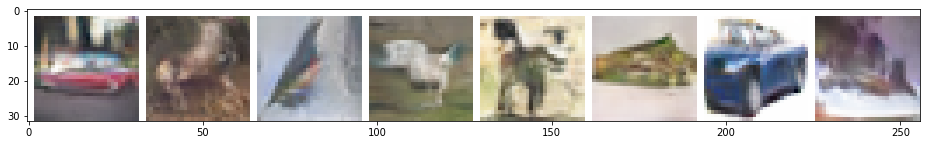

Inception score:   3.428 +-   0.040
step: 81010   time:   3.064  lr: 3.7980000e-05  loss_d:  -2.063  loss_g:   4.570
step: 81020   time:   1.217  lr: 3.7960000e-05  loss_d:  -2.072  loss_g:   4.378
step: 81030   time:   1.231  lr: 3.7940000e-05  loss_d:  -2.052  loss_g:   4.364
step: 81040   time:   1.230  lr: 3.7920000e-05  loss_d:  -2.049  loss_g:   4.728
step: 81050   time:   1.225  lr: 3.7900000e-05  loss_d:  -2.067  loss_g:   4.883
step: 81060   time:   1.230  lr: 3.7880000e-05  loss_d:  -2.062  loss_g:   4.243
step: 81070   time:   1.232  lr: 3.7860000e-05  loss_d:  -2.064  loss_g:   4.995
step: 81080   time:   1.225  lr: 3.7840000e-05  loss_d:  -2.046  loss_g:   4.473
step: 81090   time:   1.231  lr: 3.7820000e-05  loss_d:  -2.059  loss_g:   4.968
step: 81100   time:   1.227  lr: 3.7800000e-05  loss_d:  -2.077  loss_g:   4.684
step: 81110   time:   1.232  lr: 3.7780000e-05  loss_d:  -2.070  loss_g:   4.286
step: 81120   time:   1.226  lr: 3.7760000e-05  loss_d:  -2.068  loss_g: 

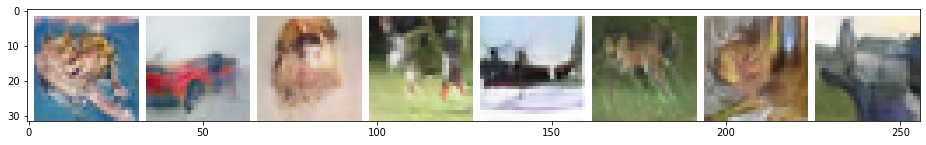

Inception score:   3.434 +-   0.068
step: 82010   time:   3.066  lr: 3.5980000e-05  loss_d:  -2.066  loss_g:   5.341
step: 82020   time:   1.229  lr: 3.5960000e-05  loss_d:  -2.077  loss_g:   4.715
step: 82030   time:   1.230  lr: 3.5940000e-05  loss_d:  -2.100  loss_g:   4.191
step: 82040   time:   1.226  lr: 3.5920000e-05  loss_d:  -2.066  loss_g:   4.770
step: 82050   time:   1.229  lr: 3.5900000e-05  loss_d:  -2.085  loss_g:   4.530
step: 82060   time:   1.233  lr: 3.5880000e-05  loss_d:  -2.075  loss_g:   5.203
step: 82070   time:   1.231  lr: 3.5860000e-05  loss_d:  -2.074  loss_g:   4.577
step: 82080   time:   1.225  lr: 3.5840000e-05  loss_d:  -2.063  loss_g:   4.652
step: 82090   time:   1.230  lr: 3.5820000e-05  loss_d:  -2.068  loss_g:   4.709
step: 82100   time:   1.229  lr: 3.5800000e-05  loss_d:  -2.066  loss_g:   5.213
step: 82110   time:   1.227  lr: 3.5780000e-05  loss_d:  -2.084  loss_g:   4.306
step: 82120   time:   1.231  lr: 3.5760000e-05  loss_d:  -2.073  loss_g: 

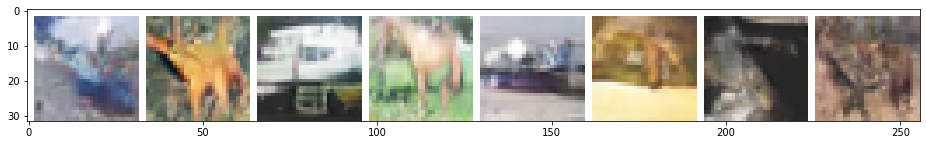

Inception score:   3.445 +-   0.067
step: 83010   time:   3.060  lr: 3.3980000e-05  loss_d:  -2.077  loss_g:   5.051
step: 83020   time:   1.222  lr: 3.3960000e-05  loss_d:  -2.078  loss_g:   4.536
step: 83030   time:   1.230  lr: 3.3940000e-05  loss_d:  -2.097  loss_g:   5.064
step: 83040   time:   1.226  lr: 3.3920000e-05  loss_d:  -2.060  loss_g:   4.528
step: 83050   time:   1.232  lr: 3.3900000e-05  loss_d:  -2.098  loss_g:   4.304
step: 83060   time:   1.225  lr: 3.3880000e-05  loss_d:  -2.068  loss_g:   4.477
step: 83070   time:   1.228  lr: 3.3860000e-05  loss_d:  -2.120  loss_g:   4.909
step: 83080   time:   1.233  lr: 3.3840000e-05  loss_d:  -2.079  loss_g:   4.689
step: 83090   time:   1.227  lr: 3.3820000e-05  loss_d:  -2.087  loss_g:   4.157
step: 83100   time:   1.227  lr: 3.3800000e-05  loss_d:  -2.079  loss_g:   4.930
step: 83110   time:   1.229  lr: 3.3780000e-05  loss_d:  -2.082  loss_g:   5.054
step: 83120   time:   1.254  lr: 3.3760000e-05  loss_d:  -2.118  loss_g: 

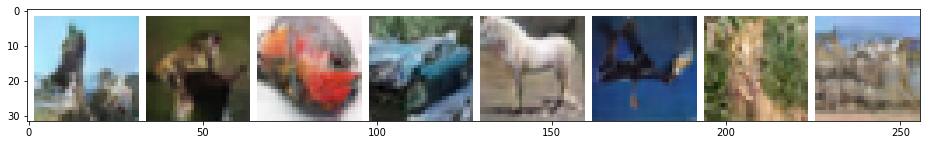

Inception score:   3.434 +-   0.060
step: 84010   time:   3.067  lr: 3.1980000e-05  loss_d:  -2.102  loss_g:   4.611
step: 84020   time:   1.227  lr: 3.1960000e-05  loss_d:  -2.123  loss_g:   4.244
step: 84030   time:   1.235  lr: 3.1940000e-05  loss_d:  -2.097  loss_g:   5.402
step: 84040   time:   1.231  lr: 3.1920000e-05  loss_d:  -2.088  loss_g:   4.805
step: 84050   time:   1.229  lr: 3.1900000e-05  loss_d:  -2.102  loss_g:   5.067
step: 84060   time:   1.227  lr: 3.1880000e-05  loss_d:  -2.104  loss_g:   4.564
step: 84070   time:   1.229  lr: 3.1860000e-05  loss_d:  -2.095  loss_g:   4.317
step: 84080   time:   1.229  lr: 3.1840000e-05  loss_d:  -2.112  loss_g:   4.736
step: 84090   time:   1.226  lr: 3.1820000e-05  loss_d:  -2.116  loss_g:   4.979
step: 84100   time:   1.228  lr: 3.1800000e-05  loss_d:  -2.093  loss_g:   5.196
step: 84110   time:   1.238  lr: 3.1780000e-05  loss_d:  -2.063  loss_g:   5.417
step: 84120   time:   1.221  lr: 3.1760000e-05  loss_d:  -2.103  loss_g: 

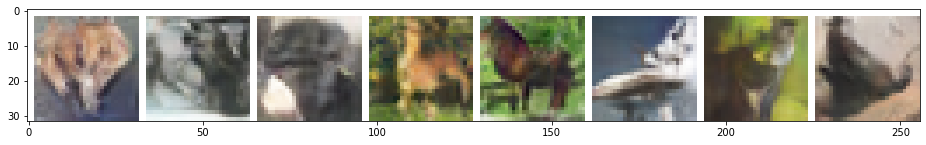

Inception score:   3.405 +-   0.063
step: 85010   time:   3.077  lr: 2.9980000e-05  loss_d:  -2.081  loss_g:   4.833
step: 85020   time:   1.222  lr: 2.9960000e-05  loss_d:  -2.088  loss_g:   3.923
step: 85030   time:   1.229  lr: 2.9940000e-05  loss_d:  -2.140  loss_g:   4.591
step: 85040   time:   1.231  lr: 2.9920000e-05  loss_d:  -2.107  loss_g:   4.677
step: 85050   time:   1.228  lr: 2.9900000e-05  loss_d:  -2.106  loss_g:   5.042
step: 85060   time:   1.226  lr: 2.9880000e-05  loss_d:  -2.090  loss_g:   4.657
step: 85070   time:   1.230  lr: 2.9860000e-05  loss_d:  -2.103  loss_g:   4.916
step: 85080   time:   1.231  lr: 2.9840000e-05  loss_d:  -2.128  loss_g:   4.716
step: 85090   time:   1.226  lr: 2.9820000e-05  loss_d:  -2.099  loss_g:   4.866
step: 85100   time:   1.232  lr: 2.9800000e-05  loss_d:  -2.091  loss_g:   4.667
step: 85110   time:   1.226  lr: 2.9780000e-05  loss_d:  -2.121  loss_g:   4.403
step: 85120   time:   1.237  lr: 2.9760000e-05  loss_d:  -2.132  loss_g: 

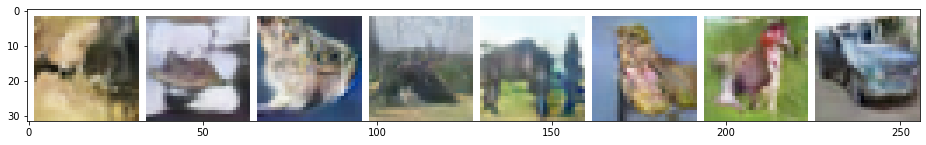

Inception score:   3.373 +-   0.073
step: 86010   time:   3.066  lr: 2.7980000e-05  loss_d:  -2.121  loss_g:   4.666
step: 86020   time:   1.235  lr: 2.7960000e-05  loss_d:  -2.112  loss_g:   4.451
step: 86030   time:   1.231  lr: 2.7940000e-05  loss_d:  -2.136  loss_g:   4.282
step: 86040   time:   1.243  lr: 2.7920000e-05  loss_d:  -2.119  loss_g:   5.046
step: 86050   time:   1.230  lr: 2.7900000e-05  loss_d:  -2.129  loss_g:   4.860
step: 86060   time:   1.230  lr: 2.7880000e-05  loss_d:  -2.114  loss_g:   5.407
step: 86070   time:   1.232  lr: 2.7860000e-05  loss_d:  -2.124  loss_g:   4.710
step: 86080   time:   1.228  lr: 2.7840000e-05  loss_d:  -2.108  loss_g:   4.912
step: 86090   time:   1.230  lr: 2.7820000e-05  loss_d:  -2.102  loss_g:   5.454
step: 86100   time:   1.227  lr: 2.7800000e-05  loss_d:  -2.140  loss_g:   4.815
step: 86110   time:   1.227  lr: 2.7780000e-05  loss_d:  -2.121  loss_g:   4.416
step: 86120   time:   1.229  lr: 2.7760000e-05  loss_d:  -2.115  loss_g: 

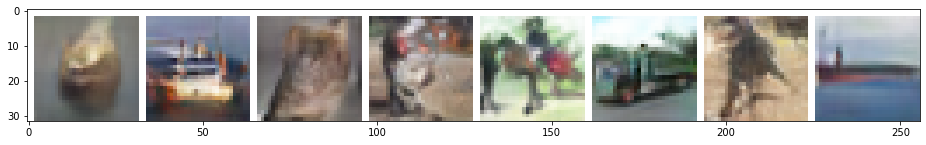

Inception score:   3.457 +-   0.079
step: 87010   time:   3.076  lr: 2.5980000e-05  loss_d:  -2.094  loss_g:   5.013
step: 87020   time:   1.228  lr: 2.5960000e-05  loss_d:  -2.116  loss_g:   4.638
step: 87030   time:   1.231  lr: 2.5940000e-05  loss_d:  -2.160  loss_g:   5.079
step: 87040   time:   1.226  lr: 2.5920000e-05  loss_d:  -2.129  loss_g:   5.213
step: 87050   time:   1.229  lr: 2.5900000e-05  loss_d:  -2.142  loss_g:   4.202
step: 87060   time:   1.236  lr: 2.5880000e-05  loss_d:  -2.115  loss_g:   5.001
step: 87070   time:   1.225  lr: 2.5860000e-05  loss_d:  -2.131  loss_g:   4.896
step: 87080   time:   1.246  lr: 2.5840000e-05  loss_d:  -2.140  loss_g:   5.060
step: 87090   time:   1.232  lr: 2.5820000e-05  loss_d:  -2.120  loss_g:   5.516
step: 87100   time:   1.227  lr: 2.5800000e-05  loss_d:  -2.114  loss_g:   5.185
step: 87110   time:   1.229  lr: 2.5780000e-05  loss_d:  -2.138  loss_g:   4.813
step: 87120   time:   1.228  lr: 2.5760000e-05  loss_d:  -2.120  loss_g: 

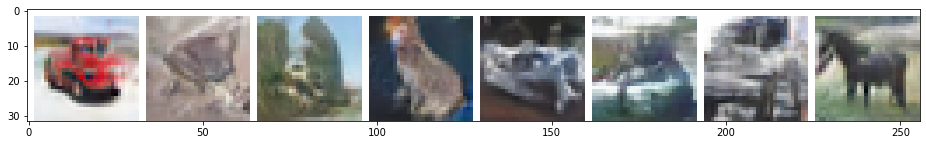

Inception score:   3.403 +-   0.060
step: 88010   time:   3.077  lr: 2.3980000e-05  loss_d:  -2.124  loss_g:   4.945
step: 88020   time:   1.224  lr: 2.3960000e-05  loss_d:  -2.152  loss_g:   4.920
step: 88030   time:   1.229  lr: 2.3940000e-05  loss_d:  -2.125  loss_g:   5.682
step: 88040   time:   1.229  lr: 2.3920000e-05  loss_d:  -2.153  loss_g:   4.998
step: 88050   time:   1.225  lr: 2.3900000e-05  loss_d:  -2.143  loss_g:   4.784
step: 88060   time:   1.231  lr: 2.3880000e-05  loss_d:  -2.155  loss_g:   5.235
step: 88070   time:   1.230  lr: 2.3860000e-05  loss_d:  -2.151  loss_g:   4.548
step: 88080   time:   1.227  lr: 2.3840000e-05  loss_d:  -2.151  loss_g:   5.167
step: 88090   time:   1.232  lr: 2.3820000e-05  loss_d:  -2.117  loss_g:   5.321
step: 88100   time:   1.225  lr: 2.3800000e-05  loss_d:  -2.127  loss_g:   5.180
step: 88110   time:   1.228  lr: 2.3780000e-05  loss_d:  -2.142  loss_g:   4.926
step: 88120   time:   1.231  lr: 2.3760000e-05  loss_d:  -2.113  loss_g: 

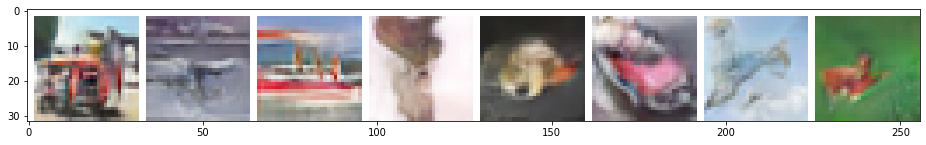

Inception score:   3.422 +-   0.076
step: 89010   time:   3.061  lr: 2.1980000e-05  loss_d:  -2.129  loss_g:   4.506
step: 89020   time:   1.218  lr: 2.1960000e-05  loss_d:  -2.163  loss_g:   5.029
step: 89030   time:   1.228  lr: 2.1940000e-05  loss_d:  -2.158  loss_g:   5.051
step: 89040   time:   1.230  lr: 2.1920000e-05  loss_d:  -2.131  loss_g:   5.143
step: 89050   time:   1.228  lr: 2.1900000e-05  loss_d:  -2.137  loss_g:   5.025
step: 89060   time:   1.227  lr: 2.1880000e-05  loss_d:  -2.124  loss_g:   4.997
step: 89070   time:   1.232  lr: 2.1860000e-05  loss_d:  -2.148  loss_g:   4.858
step: 89080   time:   1.229  lr: 2.1840000e-05  loss_d:  -2.150  loss_g:   4.534
step: 89090   time:   1.226  lr: 2.1820000e-05  loss_d:  -2.186  loss_g:   4.921
step: 89100   time:   1.235  lr: 2.1800000e-05  loss_d:  -2.150  loss_g:   5.289
step: 89110   time:   1.224  lr: 2.1780000e-05  loss_d:  -2.147  loss_g:   4.761
step: 89120   time:   1.230  lr: 2.1760000e-05  loss_d:  -2.154  loss_g: 

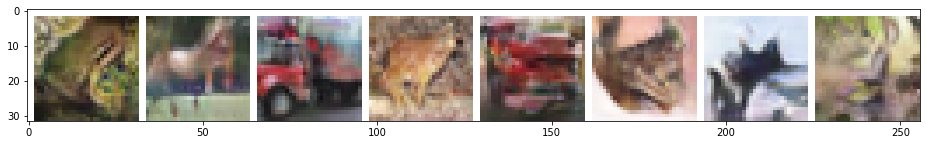

Inception score:   3.428 +-   0.052
step: 90010   time:   3.065  lr: 1.9980000e-05  loss_d:  -2.137  loss_g:   4.887
step: 90020   time:   1.231  lr: 1.9960000e-05  loss_d:  -2.179  loss_g:   4.909
step: 90030   time:   1.233  lr: 1.9940000e-05  loss_d:  -2.166  loss_g:   5.092
step: 90040   time:   1.226  lr: 1.9920000e-05  loss_d:  -2.178  loss_g:   5.064
step: 90050   time:   1.228  lr: 1.9900000e-05  loss_d:  -2.156  loss_g:   4.864
step: 90060   time:   1.232  lr: 1.9880000e-05  loss_d:  -2.147  loss_g:   5.024
step: 90070   time:   1.225  lr: 1.9860000e-05  loss_d:  -2.155  loss_g:   5.195
step: 90080   time:   1.233  lr: 1.9840000e-05  loss_d:  -2.141  loss_g:   4.737
step: 90090   time:   1.224  lr: 1.9820000e-05  loss_d:  -2.178  loss_g:   4.611
step: 90100   time:   1.230  lr: 1.9800000e-05  loss_d:  -2.168  loss_g:   4.841
step: 90110   time:   1.231  lr: 1.9780000e-05  loss_d:  -2.154  loss_g:   5.251
step: 90120   time:   1.228  lr: 1.9760000e-05  loss_d:  -2.169  loss_g: 

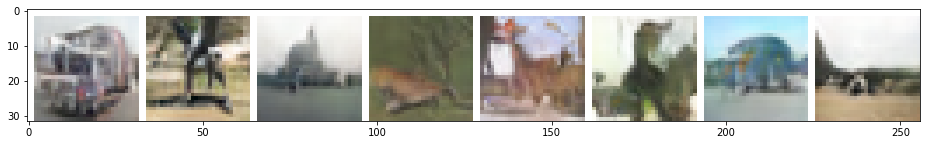

Inception score:   3.469 +-   0.080
step: 91010   time:   3.061  lr: 1.7980000e-05  loss_d:  -2.157  loss_g:   5.460
step: 91020   time:   1.219  lr: 1.7960000e-05  loss_d:  -2.182  loss_g:   5.063
step: 91030   time:   1.229  lr: 1.7940000e-05  loss_d:  -2.163  loss_g:   4.892
step: 91040   time:   1.228  lr: 1.7920000e-05  loss_d:  -2.181  loss_g:   4.767
step: 91050   time:   1.229  lr: 1.7900000e-05  loss_d:  -2.166  loss_g:   5.211
step: 91060   time:   1.229  lr: 1.7880000e-05  loss_d:  -2.150  loss_g:   5.042
step: 91070   time:   1.230  lr: 1.7860000e-05  loss_d:  -2.154  loss_g:   4.824
step: 91080   time:   1.228  lr: 1.7840000e-05  loss_d:  -2.198  loss_g:   5.022
step: 91090   time:   1.253  lr: 1.7820000e-05  loss_d:  -2.152  loss_g:   5.356
step: 91100   time:   1.232  lr: 1.7800000e-05  loss_d:  -2.183  loss_g:   5.258
step: 91110   time:   1.226  lr: 1.7780000e-05  loss_d:  -2.173  loss_g:   4.376
step: 91120   time:   1.226  lr: 1.7760000e-05  loss_d:  -2.175  loss_g: 

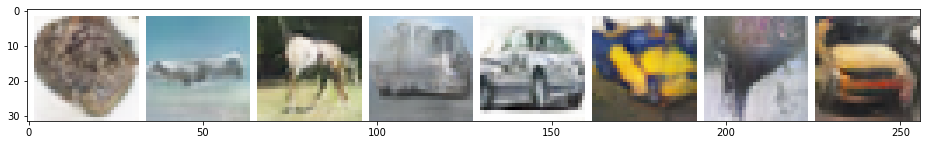

Inception score:   3.444 +-   0.063
step: 92010   time:   3.067  lr: 1.5980000e-05  loss_d:  -2.156  loss_g:   5.201
step: 92020   time:   1.231  lr: 1.5960000e-05  loss_d:  -2.196  loss_g:   5.093
step: 92030   time:   1.232  lr: 1.5940000e-05  loss_d:  -2.170  loss_g:   5.781
step: 92040   time:   1.227  lr: 1.5920000e-05  loss_d:  -2.185  loss_g:   4.842
step: 92050   time:   1.229  lr: 1.5900000e-05  loss_d:  -2.169  loss_g:   5.016
step: 92060   time:   1.228  lr: 1.5880000e-05  loss_d:  -2.197  loss_g:   4.977
step: 92070   time:   1.232  lr: 1.5860000e-05  loss_d:  -2.167  loss_g:   4.887
step: 92080   time:   1.227  lr: 1.5840000e-05  loss_d:  -2.158  loss_g:   5.110
step: 92090   time:   1.227  lr: 1.5820000e-05  loss_d:  -2.229  loss_g:   5.431
step: 92100   time:   1.230  lr: 1.5800000e-05  loss_d:  -2.182  loss_g:   5.241
step: 92110   time:   1.229  lr: 1.5780000e-05  loss_d:  -2.185  loss_g:   5.036
step: 92120   time:   1.228  lr: 1.5760000e-05  loss_d:  -2.170  loss_g: 

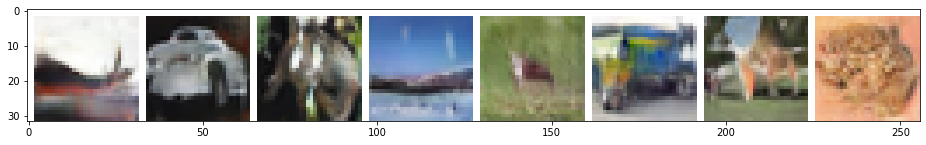

Inception score:   3.405 +-   0.073
step: 93010   time:   3.063  lr: 1.3980000e-05  loss_d:  -2.201  loss_g:   5.010
step: 93020   time:   1.217  lr: 1.3960000e-05  loss_d:  -2.178  loss_g:   5.694
step: 93030   time:   1.229  lr: 1.3940000e-05  loss_d:  -2.164  loss_g:   5.373
step: 93040   time:   1.229  lr: 1.3920000e-05  loss_d:  -2.167  loss_g:   4.859
step: 93050   time:   1.227  lr: 1.3900000e-05  loss_d:  -2.163  loss_g:   5.211
step: 93060   time:   1.232  lr: 1.3880000e-05  loss_d:  -2.185  loss_g:   5.017
step: 93070   time:   1.233  lr: 1.3860000e-05  loss_d:  -2.174  loss_g:   4.593
step: 93080   time:   1.240  lr: 1.3840000e-05  loss_d:  -2.204  loss_g:   4.896
step: 93090   time:   1.257  lr: 1.3820000e-05  loss_d:  -2.176  loss_g:   5.456
step: 93100   time:   1.222  lr: 1.3800000e-05  loss_d:  -2.174  loss_g:   5.259
step: 93110   time:   1.229  lr: 1.3780000e-05  loss_d:  -2.199  loss_g:   5.384
step: 93120   time:   1.227  lr: 1.3760000e-05  loss_d:  -2.177  loss_g: 

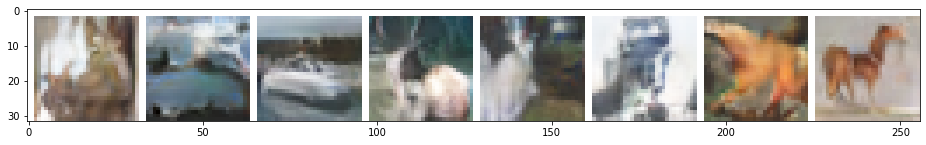

Inception score:   3.450 +-   0.068
step: 94010   time:   3.062  lr: 1.1980000e-05  loss_d:  -2.199  loss_g:   5.210
step: 94020   time:   1.230  lr: 1.1960000e-05  loss_d:  -2.213  loss_g:   5.020
step: 94030   time:   1.228  lr: 1.1940000e-05  loss_d:  -2.160  loss_g:   5.225
step: 94040   time:   1.227  lr: 1.1920000e-05  loss_d:  -2.185  loss_g:   6.117
step: 94050   time:   1.251  lr: 1.1900000e-05  loss_d:  -2.200  loss_g:   5.323
step: 94060   time:   1.233  lr: 1.1880000e-05  loss_d:  -2.217  loss_g:   5.066
step: 94070   time:   1.224  lr: 1.1860000e-05  loss_d:  -2.180  loss_g:   5.488
step: 94080   time:   1.229  lr: 1.1840000e-05  loss_d:  -2.203  loss_g:   4.753
step: 94090   time:   1.229  lr: 1.1820000e-05  loss_d:  -2.203  loss_g:   5.049
step: 94100   time:   1.233  lr: 1.1800000e-05  loss_d:  -2.174  loss_g:   5.115
step: 94110   time:   1.225  lr: 1.1780000e-05  loss_d:  -2.203  loss_g:   4.898
step: 94120   time:   1.233  lr: 1.1760000e-05  loss_d:  -2.191  loss_g: 

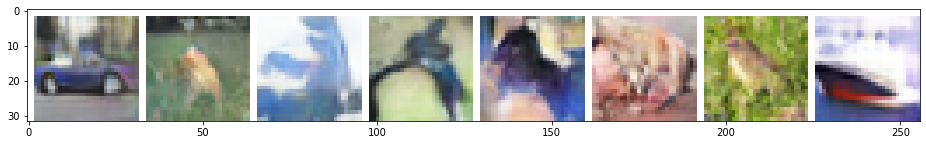

Inception score:   3.477 +-   0.066
step: 95010   time:   3.061  lr: 9.9800000e-06  loss_d:  -2.191  loss_g:   5.311
step: 95020   time:   1.218  lr: 9.9600000e-06  loss_d:  -2.183  loss_g:   4.959
step: 95030   time:   1.235  lr: 9.9400000e-06  loss_d:  -2.200  loss_g:   5.327
step: 95040   time:   1.253  lr: 9.9200000e-06  loss_d:  -2.203  loss_g:   5.482
step: 95050   time:   1.239  lr: 9.9000000e-06  loss_d:  -2.200  loss_g:   5.334
step: 95060   time:   1.244  lr: 9.8800000e-06  loss_d:  -2.196  loss_g:   5.493
step: 95070   time:   1.233  lr: 9.8600000e-06  loss_d:  -2.193  loss_g:   5.396
step: 95080   time:   1.228  lr: 9.8400000e-06  loss_d:  -2.216  loss_g:   5.156
step: 95090   time:   1.233  lr: 9.8200000e-06  loss_d:  -2.215  loss_g:   5.022
step: 95100   time:   1.226  lr: 9.8000000e-06  loss_d:  -2.231  loss_g:   4.977
step: 95110   time:   1.230  lr: 9.7800000e-06  loss_d:  -2.200  loss_g:   5.616
step: 95120   time:   1.227  lr: 9.7600000e-06  loss_d:  -2.211  loss_g: 

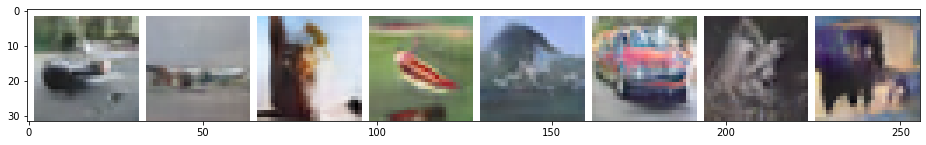

Inception score:   3.457 +-   0.068
step: 96010   time:   3.059  lr: 7.9800000e-06  loss_d:  -2.205  loss_g:   5.514
step: 96020   time:   1.222  lr: 7.9600000e-06  loss_d:  -2.213  loss_g:   5.183
step: 96030   time:   1.228  lr: 7.9400000e-06  loss_d:  -2.235  loss_g:   5.103
step: 96040   time:   1.229  lr: 7.9200000e-06  loss_d:  -2.210  loss_g:   5.181
step: 96050   time:   1.248  lr: 7.9000000e-06  loss_d:  -2.227  loss_g:   5.420
step: 96060   time:   1.230  lr: 7.8800000e-06  loss_d:  -2.217  loss_g:   4.884
step: 96070   time:   1.227  lr: 7.8600000e-06  loss_d:  -2.210  loss_g:   5.477
step: 96080   time:   1.251  lr: 7.8400000e-06  loss_d:  -2.199  loss_g:   5.413
step: 96090   time:   1.227  lr: 7.8200000e-06  loss_d:  -2.241  loss_g:   5.035
step: 96100   time:   1.231  lr: 7.8000000e-06  loss_d:  -2.202  loss_g:   5.046
step: 96110   time:   1.229  lr: 7.7800000e-06  loss_d:  -2.228  loss_g:   5.220
step: 96120   time:   1.229  lr: 7.7600000e-06  loss_d:  -2.213  loss_g: 

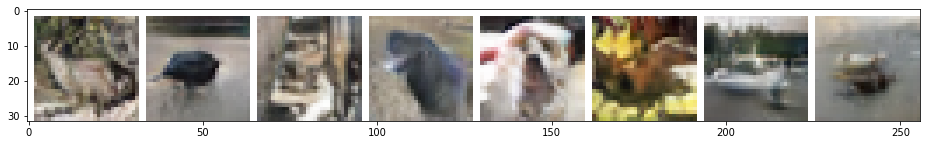

Inception score:   3.475 +-   0.042
step: 97010   time:   3.055  lr: 5.9800000e-06  loss_d:  -2.217  loss_g:   5.558
step: 97020   time:   1.225  lr: 5.9600000e-06  loss_d:  -2.212  loss_g:   5.497
step: 97030   time:   1.232  lr: 5.9400000e-06  loss_d:  -2.237  loss_g:   5.065
step: 97040   time:   1.225  lr: 5.9200000e-06  loss_d:  -2.192  loss_g:   5.576
step: 97050   time:   1.228  lr: 5.9000000e-06  loss_d:  -2.217  loss_g:   4.947
step: 97060   time:   1.229  lr: 5.8800000e-06  loss_d:  -2.230  loss_g:   4.805
step: 97070   time:   1.230  lr: 5.8600000e-06  loss_d:  -2.252  loss_g:   4.911
step: 97080   time:   1.232  lr: 5.8400000e-06  loss_d:  -2.201  loss_g:   5.386
step: 97090   time:   1.225  lr: 5.8200000e-06  loss_d:  -2.194  loss_g:   5.862
step: 97100   time:   1.229  lr: 5.8000000e-06  loss_d:  -2.235  loss_g:   5.263
step: 97110   time:   1.229  lr: 5.7800000e-06  loss_d:  -2.210  loss_g:   5.438
step: 97120   time:   1.233  lr: 5.7600000e-06  loss_d:  -2.226  loss_g: 

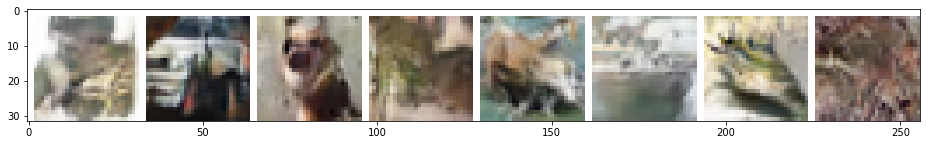

Inception score:   3.434 +-   0.050
step: 98010   time:   3.059  lr: 3.9800000e-06  loss_d:  -2.224  loss_g:   5.071
step: 98020   time:   1.219  lr: 3.9600000e-06  loss_d:  -2.238  loss_g:   5.081
step: 98030   time:   1.230  lr: 3.9400000e-06  loss_d:  -2.209  loss_g:   5.504
step: 98040   time:   1.231  lr: 3.9200000e-06  loss_d:  -2.216  loss_g:   5.273
step: 98050   time:   1.228  lr: 3.9000000e-06  loss_d:  -2.233  loss_g:   5.023
step: 98060   time:   1.229  lr: 3.8800000e-06  loss_d:  -2.229  loss_g:   5.178
step: 98070   time:   1.226  lr: 3.8600000e-06  loss_d:  -2.244  loss_g:   5.099
step: 98080   time:   1.233  lr: 3.8400000e-06  loss_d:  -2.250  loss_g:   5.264
step: 98090   time:   1.224  lr: 3.8200000e-06  loss_d:  -2.213  loss_g:   5.133
step: 98100   time:   1.230  lr: 3.8000000e-06  loss_d:  -2.216  loss_g:   5.676
step: 98110   time:   1.232  lr: 3.7800000e-06  loss_d:  -2.231  loss_g:   5.469
step: 98120   time:   1.225  lr: 3.7600000e-06  loss_d:  -2.223  loss_g: 

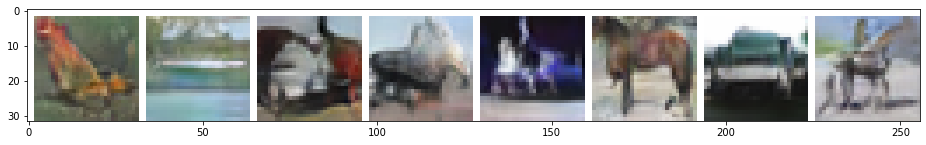

Inception score:   3.443 +-   0.082
step: 99010   time:   3.058  lr: 1.9800000e-06  loss_d:  -2.221  loss_g:   5.294
step: 99020   time:   1.223  lr: 1.9600000e-06  loss_d:  -2.266  loss_g:   5.040
step: 99030   time:   1.232  lr: 1.9400000e-06  loss_d:  -2.194  loss_g:   5.328
step: 99040   time:   1.224  lr: 1.9200000e-06  loss_d:  -2.201  loss_g:   5.419
step: 99050   time:   1.230  lr: 1.9000000e-06  loss_d:  -2.213  loss_g:   5.348
step: 99060   time:   1.230  lr: 1.8800000e-06  loss_d:  -2.261  loss_g:   5.529
step: 99070   time:   1.228  lr: 1.8600000e-06  loss_d:  -2.244  loss_g:   5.243
step: 99080   time:   1.229  lr: 1.8400000e-06  loss_d:  -2.227  loss_g:   5.231
step: 99090   time:   1.230  lr: 1.8200000e-06  loss_d:  -2.243  loss_g:   5.052
step: 99100   time:   1.228  lr: 1.8000000e-06  loss_d:  -2.224  loss_g:   5.011
step: 99110   time:   1.231  lr: 1.7800000e-06  loss_d:  -2.278  loss_g:   5.194
step: 99120   time:   1.225  lr: 1.7600000e-06  loss_d:  -2.234  loss_g: 

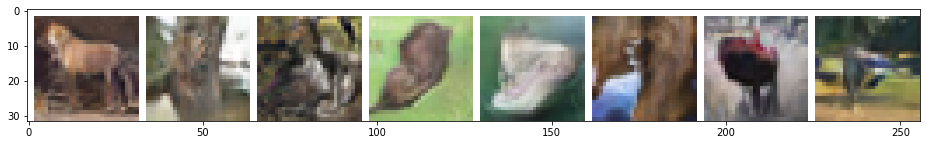

Inception score:   3.439 +-   0.053


In [11]:
d_losses_tot, g_losses_tot, is_means, is_stds, fakes_ = train(nrof_steps=100000, batch_size=128, n_filters=256)

/home/david/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/david/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


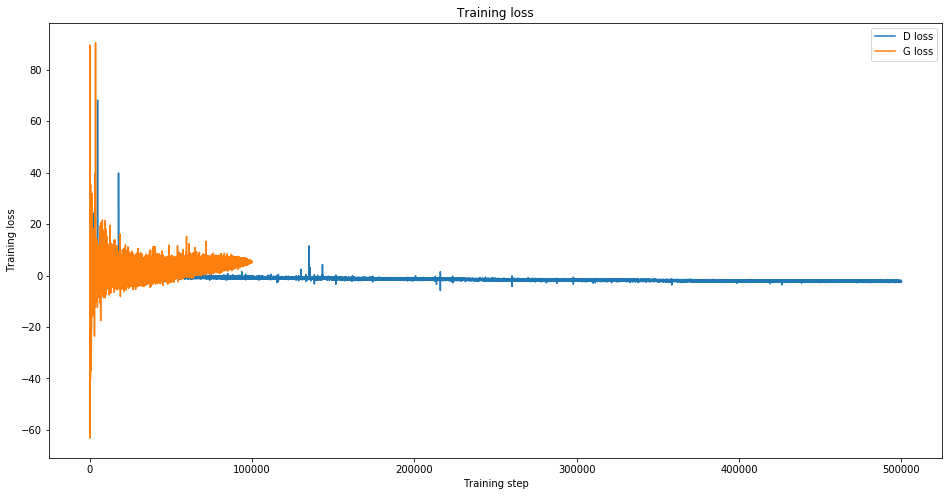

In [12]:
plt.figure(figsize=(16,8))
plt.plot(d_losses_tot)
plt.plot(g_losses_tot)
plt.title('Training loss')
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.legend(['D loss', 'G loss'])

Text(0, 0.5, 'Inception score')

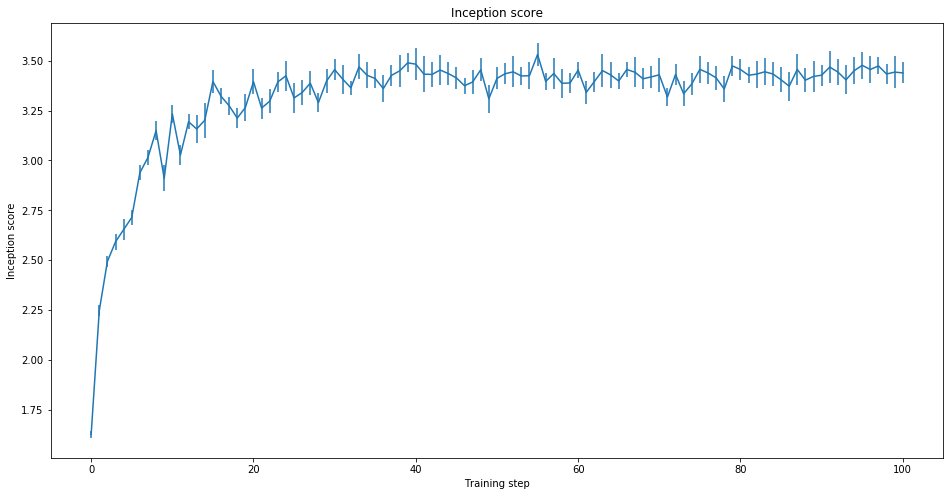

In [13]:
plt.figure(figsize=(16,8))
plt.errorbar(x=np.arange(len(is_means)), y=is_means, yerr=is_stds)
plt.title('Inception score')
plt.xlabel('Training step')
plt.ylabel('Inception score')

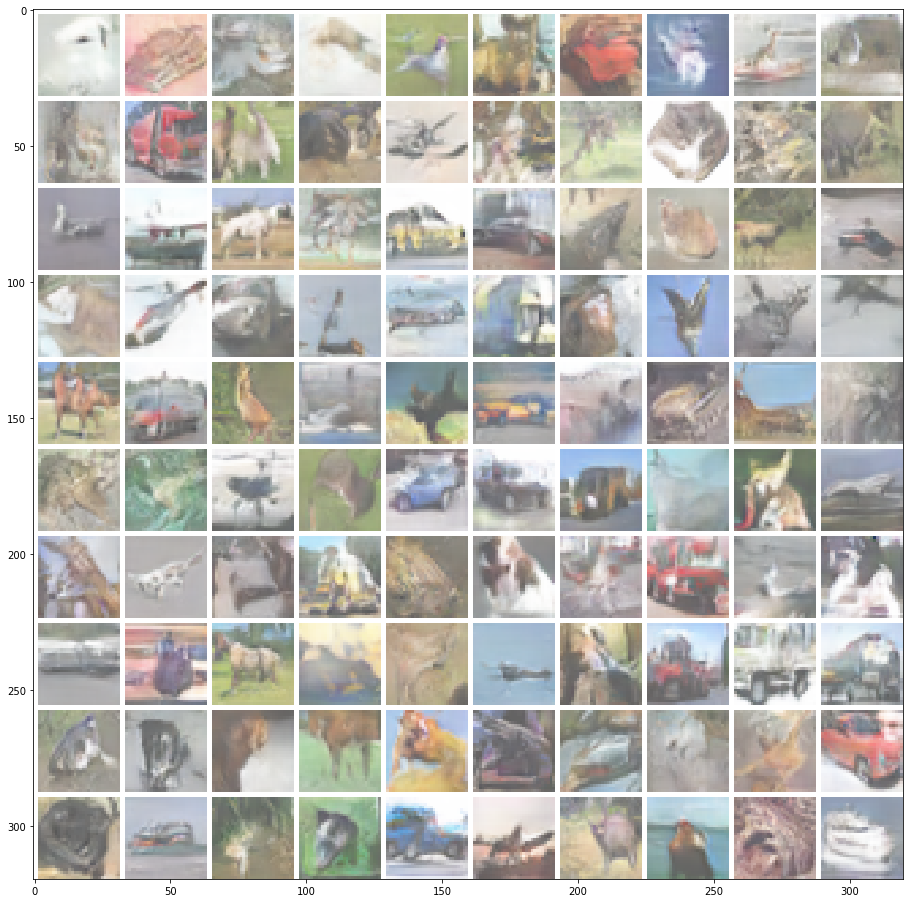

In [14]:
plt.figure(figsize=(16,16))
imgs = (fakes_-np.min(fakes_)) / (np.max(fakes_)-np.min(fakes_))
show_images(imgs[:100,...], 10)

# Train with batch_size=256 and n_filters=128¶

In [ ]:
d_losses_tot, g_losses_tot, is_means, is_stds, fakes_ = train(nrof_steps=100000, batch_size=256, n_filters=128)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(d_losses_tot)
plt.plot(g_losses_tot)
plt.title('Training loss')
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.legend(['D loss', 'G loss'])

In [ ]:
plt.figure(figsize=(16,8))
plt.errorbar(x=np.arange(len(is_means)), y=is_means, yerr=is_stds)
plt.title('Inception score')
plt.xlabel('Training step')
plt.ylabel('Inception score')

In [ ]:
plt.figure(figsize=(16,16))
imgs = (fakes_-np.min(fakes_)) / (np.max(fakes_)-np.min(fakes_))
show_images(imgs[:100,...], 10)